In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime
from utils import *
import pyreadr
import os

home = os.getcwd()

## Importing Net Load data from Groups C (Greater London) and P (Northern Scotland)

In [3]:
GroupC = pyreadr.read_r(home + '\\Other_data\\GroupC.rda')
GroupP = pyreadr.read_r(home + '\\Other_data\\GroupP.rda')

GroupC_df = pd.DataFrame(list(GroupC.values())[0])
GroupP_df = pd.DataFrame(list(GroupP.values())[0])

# Group C - Greater London

## 1) Seasonality - Net Load

In [4]:
GroupC_df["node"].describe()

count    138192.000000
mean       1564.638564
std         373.623033
min         797.149000
25%        1250.964500
50%        1554.327000
75%        1854.487750
max        2679.683000
Name: node, dtype: float64

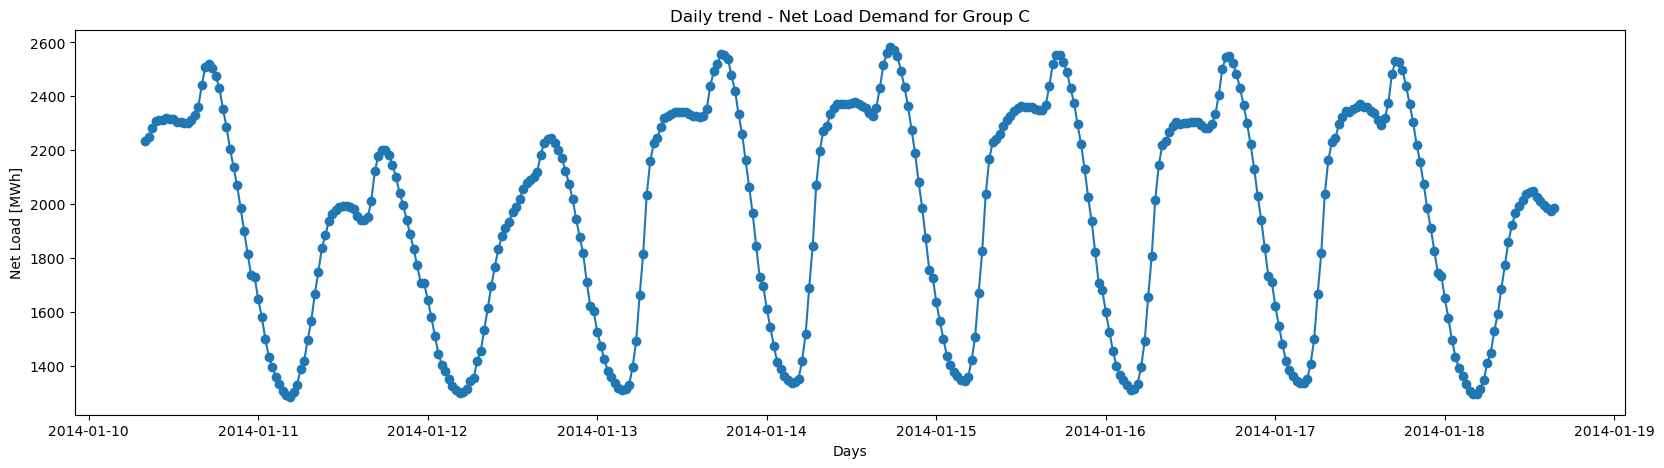

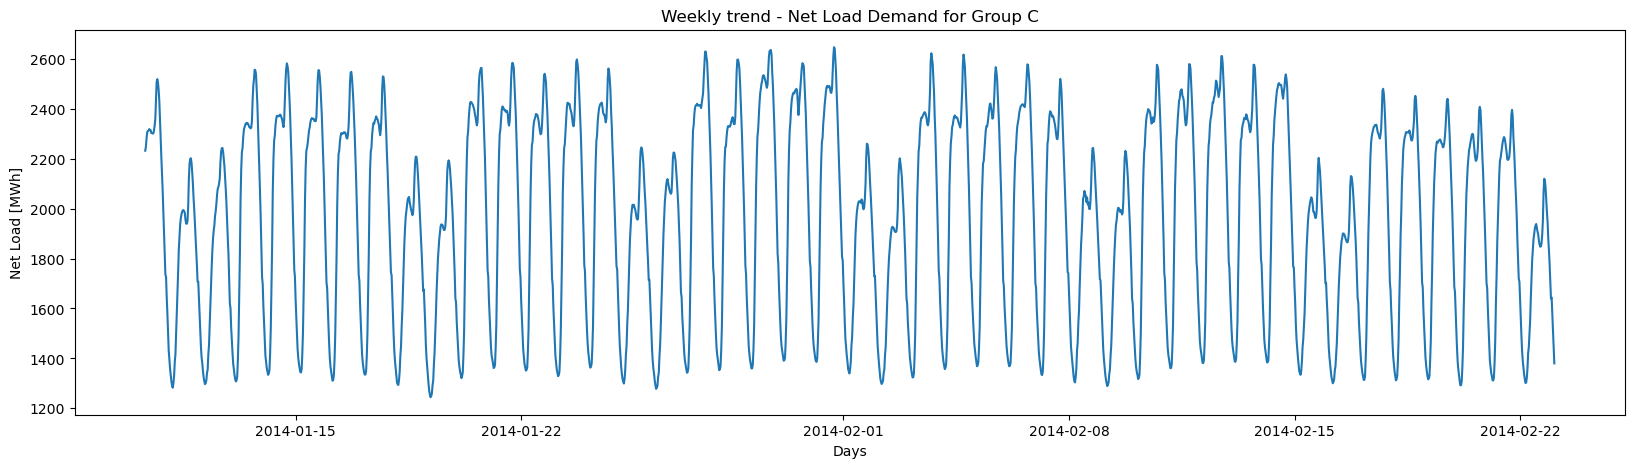

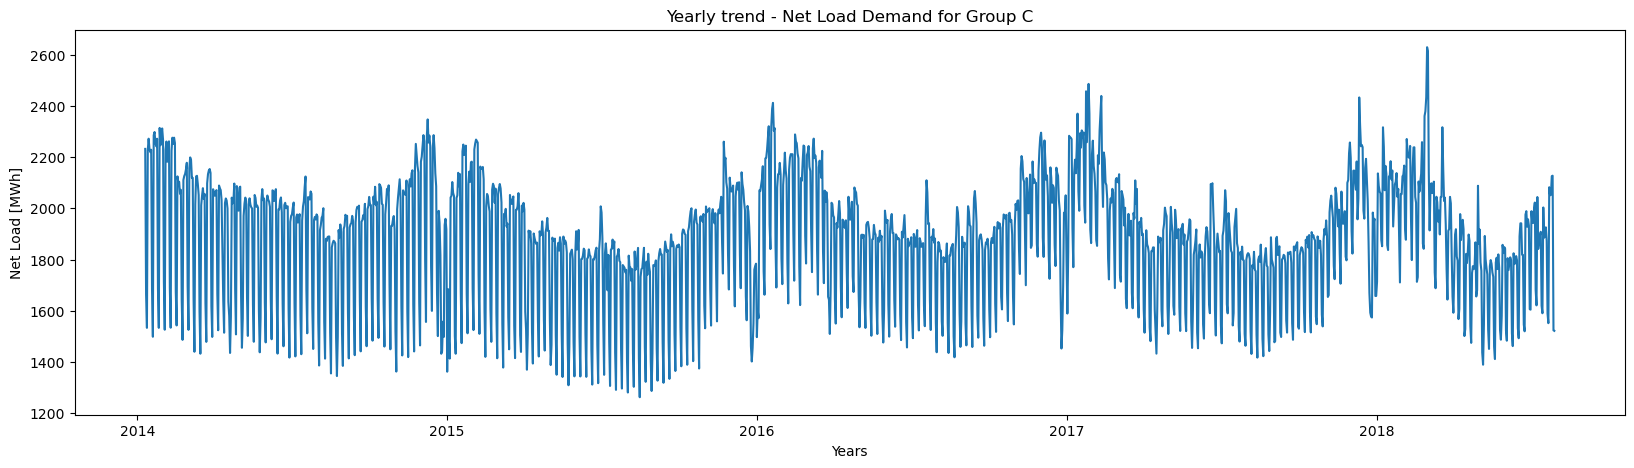

In [5]:
fig, axs = plt.subplots(1,1, figsize=(20,5))
axs.plot(GroupC_df["targetTime"][400:800], GroupC_df["node"][400:800], '-o')
axs.set_title("Daily trend - Net Load Demand for Group C")
axs.set_xlabel("Days");
axs.set_ylabel("Net Load [MWh]");

fig, axs = plt.subplots(1,1, figsize=(20,5))
axs.plot(GroupC_df["targetTime"][400:2500], GroupC_df["node"][400:2500])
axs.set_title("Weekly trend - Net Load Demand for Group C")
axs.set_xlabel("Days");
axs.set_ylabel("Net Load [MWh]");

fig, axs = plt.subplots(1,1, figsize=(20,5))
axs.plot(GroupC_df["targetTime"][400:80000:48], GroupC_df["node"][400:80000:48])
axs.set_title("Yearly trend - Net Load Demand for Group C")
axs.set_xlabel("Years");
axs.set_ylabel("Net Load [MWh]");

## 2) Partial Auto Correlation Function PACF

In [6]:
def Seasonality(t, dow, doy, clock_hour):
    # seasonality on yearly scale
    #wy = 2*np.pi/365
    wy = 2*np.pi/(336*52)
    # seasonality on weekly scale: we look for weekend days
    is_saturday = dow == 'Sam'
    is_sunday = dow == 'Dim'
    day_of_week = 1*(dow=='Lun')+2*(dow=='Mar')+3*(dow=='Mer')+4*(dow=='Jeu')+5*(dow=='Ven')+6*(dow=='Sam')+7*(dow=='Dim')
    #ww = 2*np.pi/7
    ww = 2*np.pi/336
    # seasonality on daily scale
    #wd = 2*np.pi/24
    wd = 2*np.pi/48
    
    
    St = np.array([np.ones(doy.shape), t, np.cos(wy*doy), np.sin(wy*doy), is_saturday, is_sunday, np.cos(ww*day_of_week),
                   np.sin(ww*day_of_week), 
                   day_of_week*np.cos(wd*clock_hour), day_of_week*np.sin(wd*clock_hour),
                   np.cos(wd*clock_hour), np.sin(wd*clock_hour), np.cos(wd*clock_hour)*np.sin(wd*clock_hour),
                   np.cos(2*wd*clock_hour), np.sin(2*wd*clock_hour),np.cos(3*wd*clock_hour), 
                   np.sin(3*wd*clock_hour), np.cos(4*wd*clock_hour), np.sin(4*wd*clock_hour)]).T
    return St

### Trend and Seasonality Description

In [7]:
St = Seasonality(GroupC_df["t"],GroupC_df["dow"], GroupC_df["doy"], GroupC_df["clock_hour"])
Yt = GroupC_df["node"] #Net-Load to predict

model = sm.OLS(Yt, St)
results = model.fit()
params = results.params
print("Parameters: ", results.params)
print("RMSE: ", RMSE(Yt, St@params))

Parameters:  const    139999.776604
x1         -405.188191
x2      -171888.861433
x3       -12083.276346
x4         -142.527624
x5         -149.960373
x6        32470.090862
x7         4371.410757
x8            3.729439
x9          -74.465565
x10        -306.412546
x11        2595.665806
x12          71.327699
x13        1192.042479
x14         142.655398
x15         299.116351
x16        -694.409489
x17        -227.457972
x18        -239.413825
dtype: float64
RMSE:  134.79707132634312


In [8]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   node   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                 5.431e+04
Date:                Fri, 15 Dec 2023   Prob (F-statistic):               0.00
Time:                        18:18:14   Log-Likelihood:            -8.7375e+05
No. Observations:              138192   AIC:                         1.748e+06
Df Residuals:                  138174   BIC:                         1.748e+06
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         1.4e+05   1575.187     88.878      0.000    1.37e+05    1.43e+05
x1          -405.1882      1.262   -321.017      0.000    -407.662    -402.714
x2         -1.719e+05    570.085   -301.515      0.000   -1.73e+05   -1.71e+05
x3         -1.208e+04     38.542   -313.507      0.000   -1.22e+04    -1.2e+04
x4          -142.5276      2.270    -62.775      0.000    -146.978    -138.078
x5          -149.9604      3.932    -38.137      0.000    -157.667    -142.253
x6          3.247e+04   1464.327     22.174      0.000    2.96e+04    3.53e+04
x7          4371.4108     86.151     50.741      0.000    4202.556    4540.265
x8             3.7294      0.257     14.511      0.000       3.226       4.233
x9           -74.4656      0.589   -126.343      0.000     -75.621     -73.310
x10         -306.4125     13.542    -22.626      0.000    -332.956    -279.870
x11         2595.6658    148.931     17.429      0.000    2303.764    2887.568
x12           71.3277      6.965     10.240      0.000      57.676      84.980
x13         1192.0425     93.717     12.720      0.000    1008.359    1375.726
x14          142.6554     13.931     10.240      0.000     115.351     169.960
x15          299.1164     11.714     25.535      0.000     276.157     322.075
x16         -694.4095     40.064    -17.333      0.000    -772.933    -615.886
x17         -227.4580      9.352    -24.322      0.000    -245.788    -209.128
x18         -239.4138      4.024    -59.492      0.000    -247.301    -231.526
==============================================================================
Omnibus:                     7124.042   Durbin-Watson:                   0.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16033.264
Skew:                          -0.337   Prob(JB):                         0.00
Kurtosis:                       4.527   Cond. No.                     6.49e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.23e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

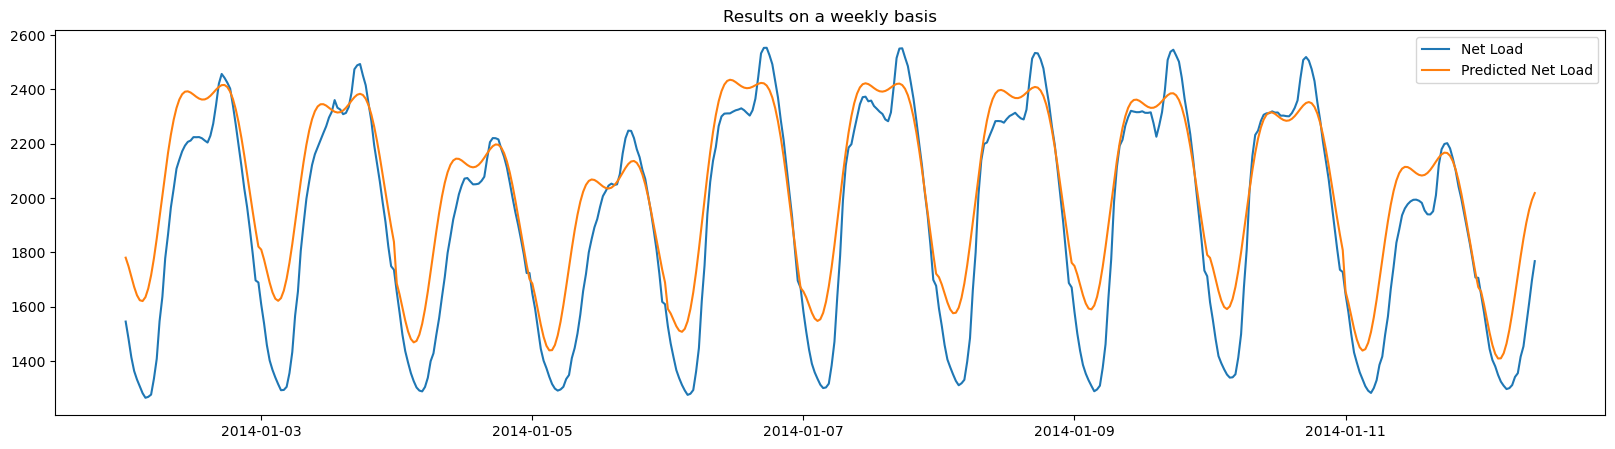

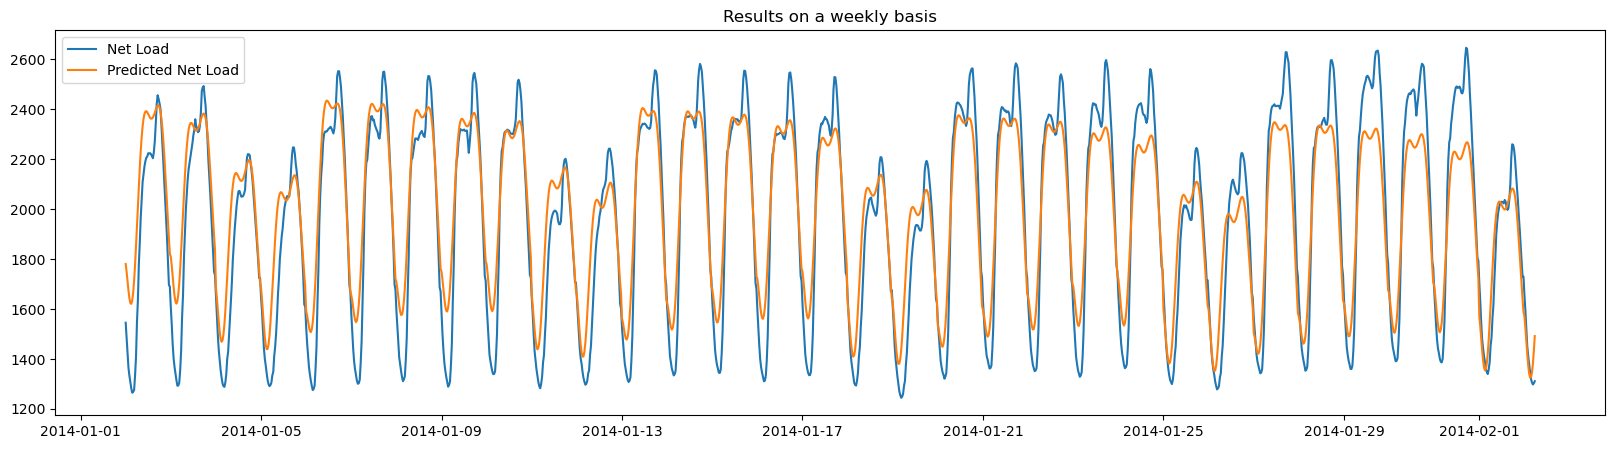

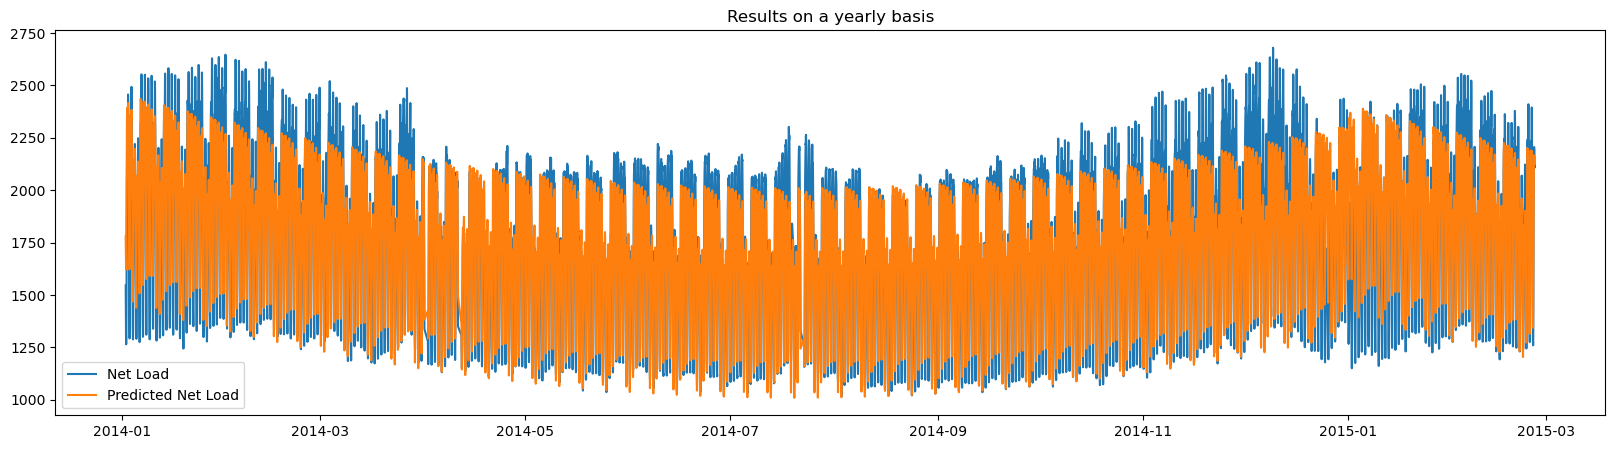

In [9]:
fig, axs = plt.subplots(1,1,figsize=(20,5))
axs.plot(GroupC_df["targetTime"][:500],Yt[:500], label='Net Load')
axs.plot(GroupC_df["targetTime"][:500],(St@params)[:500], label='Predicted Net Load')
axs.set_title('Results on a weekly basis')
axs.legend()

fig, axs = plt.subplots(1,1,figsize=(20,5))
axs.plot(GroupC_df["targetTime"][:1500],Yt[:1500], label='Net Load')
axs.plot(GroupC_df["targetTime"][:1500],(St@params)[:1500], label='Predicted Net Load')
axs.set_title('Results on a weekly basis')
axs.legend()

fig, axs = plt.subplots(1,1,figsize=(20,5))
axs.plot(GroupC_df["targetTime"][:20000],Yt[:20000], label='Net Load')
axs.plot(GroupC_df["targetTime"][:20000],(St@params)[:20000], label='Predicted Net Load')
axs.set_title('Results on a yearly basis')
axs.legend();


### Deseasonalizing process
We define Xt := Yt - St and subtract the values of the previous week to deseasonalize

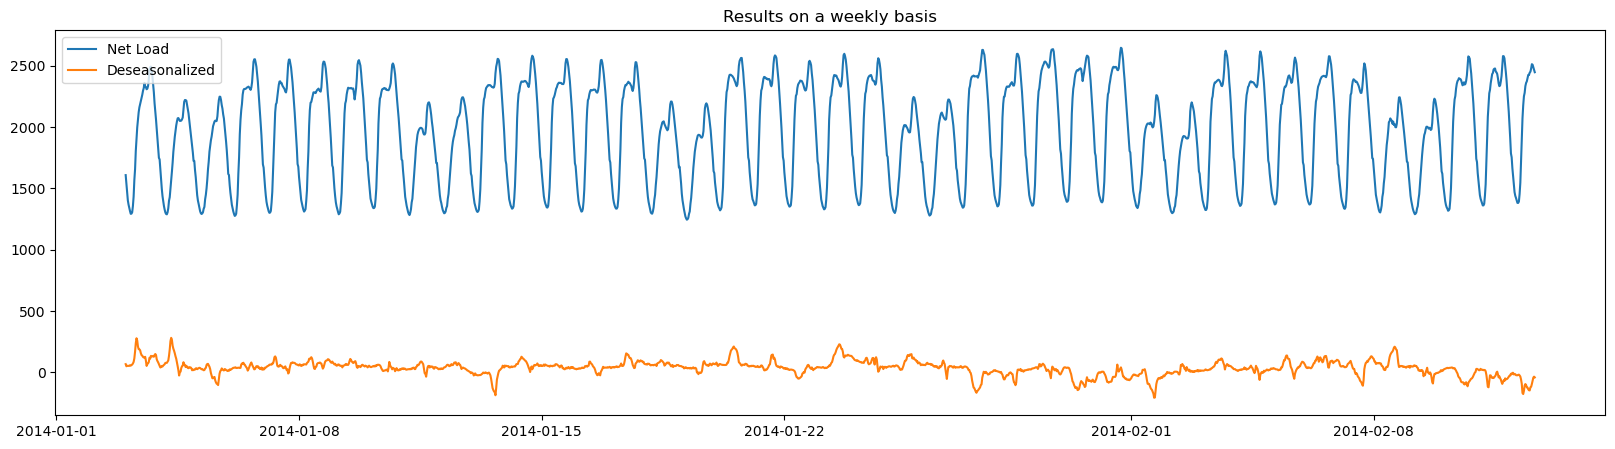

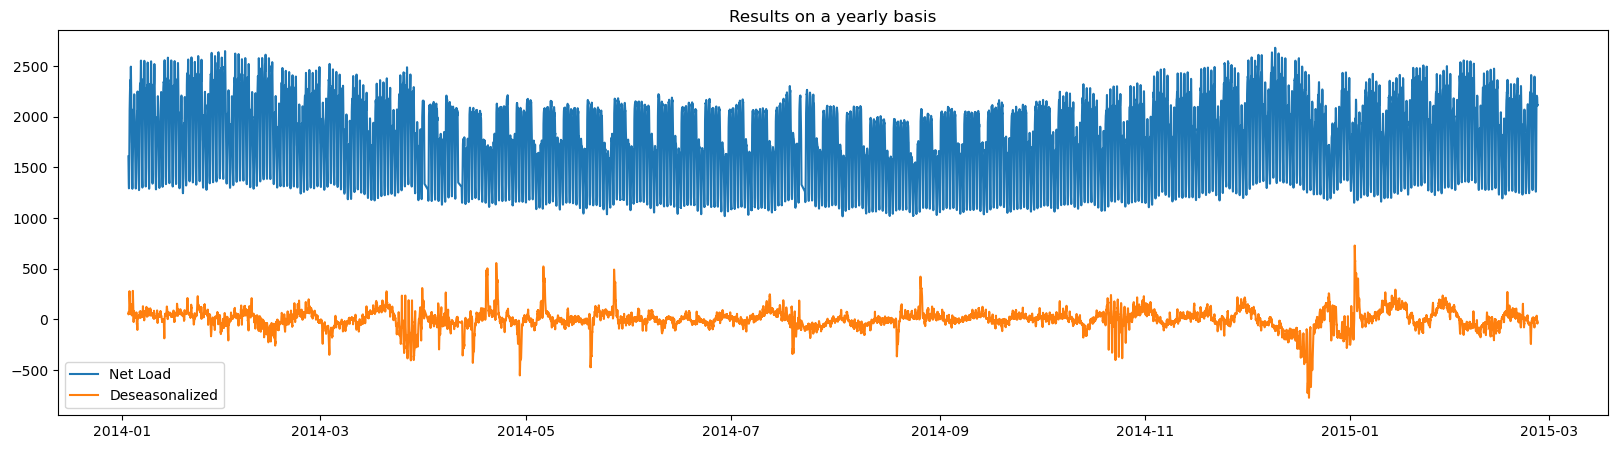

In [10]:
Xt = np.array((Yt - St@params)[336:]) - np.array((Yt - St@params)[:-336]) 
fig, axs = plt.subplots(1,1,figsize=(20,5))
axs.plot(GroupC_df["targetTime"][48:2000],Yt[48:2000], label='Net Load')
axs.plot(GroupC_df["targetTime"][48:2000],Xt[:2000-48], label='Deseasonalized')
axs.set_title('Results on a weekly basis')
axs.legend()

fig, axs = plt.subplots(1,1,figsize=(20,5))
axs.plot(GroupC_df["targetTime"][48:20000],Yt[48:20000], label='Net Load')
axs.plot(GroupC_df["targetTime"][48:20000],Xt[:20000-48], label='Deseasonalized')
axs.set_title('Results on a yearly basis')
axs.legend();

C:\Users\Utente\AppData\Local\Temp\ipykernel_9068\2751606838.py:4: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(range(400), acf(Xt, nlags=399), 'o')
C:\Users\Utente\AppData\Local\Temp\ipykernel_9068\2751606838.py:11: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(range(400), pacf(Xt, nlags=399), 'o')


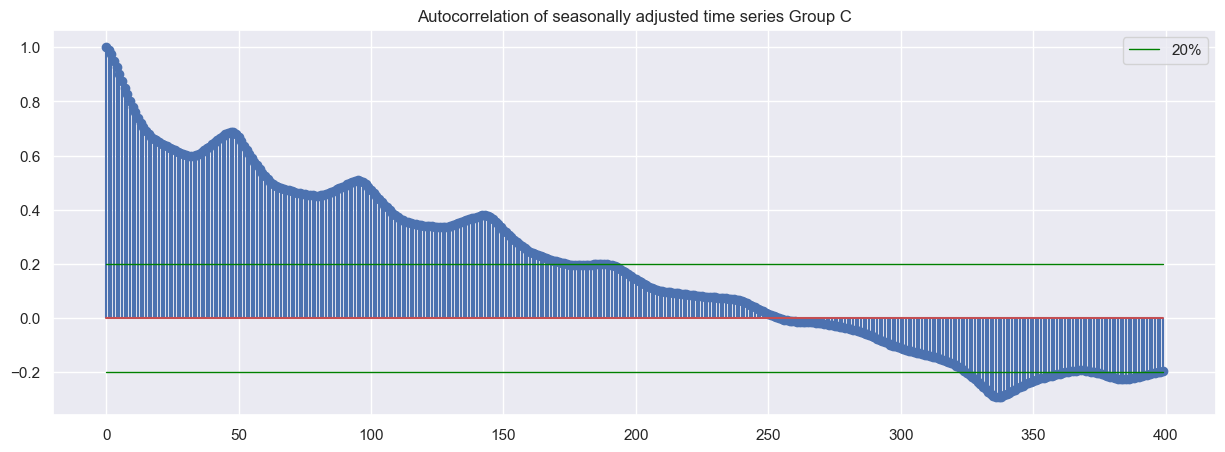

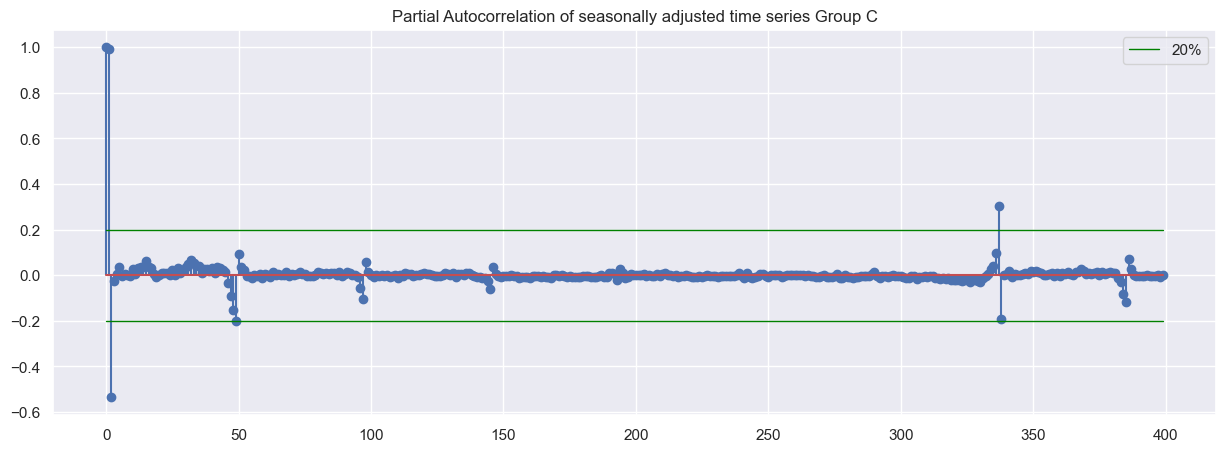

In [136]:
from statsmodels.tsa.stattools import pacf, acf

fig, axs = plt.subplots(1,1,figsize=(15,5))
plt.stem(range(400), acf(Xt, nlags=399), 'o')
plt.plot(range(400), 0.2*np.ones(400,), color='green', linewidth=1, label='20%')
plt.plot(range(400), -0.2*np.ones(400,), color='green', linewidth=1)
plt.title('Autocorrelation of seasonally adjusted time series Group C');
plt.legend()

fig, axs = plt.subplots(1,1,figsize=(15,5))
plt.stem(range(400), pacf(Xt, nlags=399), 'o')
plt.plot(range(400), 0.2*np.ones(400,), color='green', linewidth=1, label='20%')
plt.plot(range(400), -0.2*np.ones(400,), color='green', linewidth=1)
plt.title('Partial Autocorrelation of seasonally adjusted time series Group C');
plt.legend()

The Partial Autocorrelation plot suggests to introduce four AR terms: lag 1, lag 2, lag 48 (daily) and lag 336 (weekly)

Yt = params*St + beta1 * Y(t-1) + beta2 * Y(t-2) + beta3 * Y(t-48) + beta4 * Y(t-336)  + Rt


In [137]:
Yt_AR = GroupC_df["node"].iloc[336:]
St_AR = Seasonality(GroupC_df["t"].iloc[336:],GroupC_df["dow"].iloc[336:], GroupC_df["doy"].iloc[336:], GroupC_df["clock_hour"].iloc[336:])
features = np.c_[St_AR, GroupC_df["node"].iloc[336-1:-1], GroupC_df["node"].iloc[336-2:-2],
                GroupC_df["node"].iloc[336-48:-48], GroupC_df["node"].iloc[:-336]]

model = sm.OLS(Yt_AR, features)
results = model.fit()
params = results.params
print("Parameters: ", results.params)
print("RMSE: ", RMSE(Yt_AR, features@params))

Parameters:  const    31.697425
x1       -6.566432
x2        2.691126
x3        0.125132
x4      -12.033366
x5      -11.386014
x6        3.428271
x7        1.067428
x8        1.178139
x9       -1.554038
x10     -17.397540
x11      18.363125
x12       2.276048
x13     -11.208981
x14       4.552095
x15       2.251613
x16      -3.145065
x17       4.271142
x18      -3.014441
x19       1.539347
x20      -0.603119
x21       0.030871
x22       0.016882
dtype: float64
RMSE:  18.14738473178451


In [138]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   node   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.768e+06
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:07:45   Log-Likelihood:            -5.9519e+05
No. Observations:              137856   AIC:                         1.190e+06
Df Residuals:                  137834   BIC:                         1.191e+06
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.6974      0.734     43.166      0.000      30.258      33.137
x1            -6.5664      0.236    -27.767      0.000      -7.030      -6.103
x2             2.6911      0.094     28.529      0.000       2.506       2.876
x3             0.1251      0.072      1.746      0.081      -0.015       0.266
x4           -12.0334      0.262    -45.964      0.000     -12.546     -11.520
x5           -11.3860      0.250    -45.582      0.000     -11.876     -10.896
x6             3.4283      0.127     27.034      0.000       3.180       3.677
x7             1.0674      0.085     12.568      0.000       0.901       1.234
x8             1.1781      0.040     29.237      0.000       1.099       1.257
x9            -1.5540      0.036    -43.525      0.000      -1.624      -1.484
x10          -17.3975      0.236    -73.571      0.000     -17.861     -16.934
x11           18.3631      0.219     83.766      0.000      17.933      18.793
x12            2.2760      0.034     66.960      0.000       2.209       2.343
x13          -11.2090      0.098   -113.832      0.000     -11.402     -11.016
x14            4.5521      0.068     66.960      0.000       4.419       4.685
x15            2.2516      0.072     31.440      0.000       2.111       2.392
x16           -3.1451      0.070    -45.148      0.000      -3.282      -3.009
x17            4.2711      0.072     59.448      0.000       4.130       4.412
x18           -3.0144      0.070    -42.980      0.000      -3.152      -2.877
x19            1.5393      0.002    693.625      0.000       1.535       1.544
x20           -0.6031      0.002   -288.948      0.000      -0.607      -0.599
x21            0.0309      0.001     57.267      0.000       0.030       0.032
x22            0.0169      0.001     33.549      0.000       0.016       0.018
==============================================================================
Omnibus:                    23062.999   Durbin-Watson:                   2.177
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           118347.505
Skew:                           0.719   Prob(JB):                         0.00
Kurtosis:                       7.305   Cond. No.                     2.71e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.94e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Impact of Autoregressive term

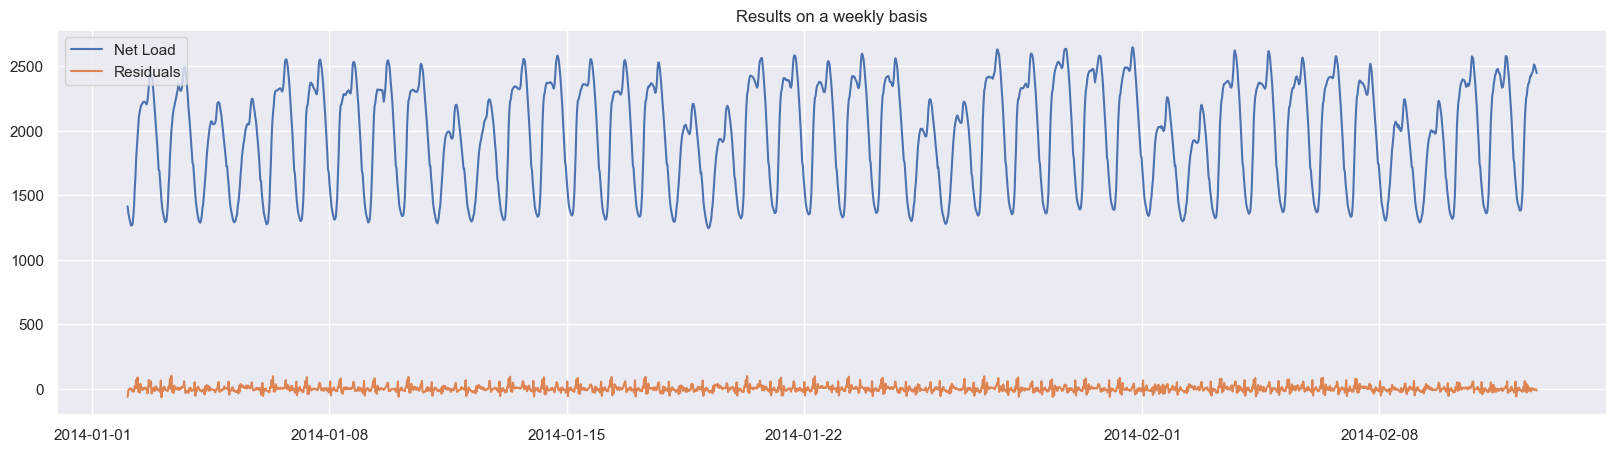

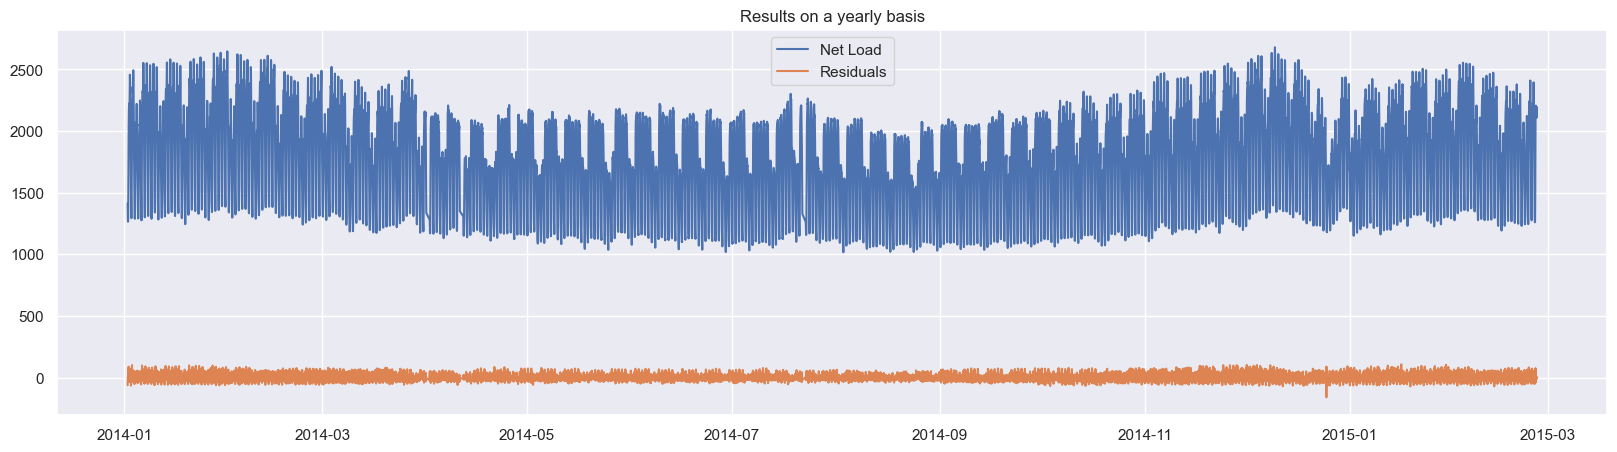

In [139]:
# Residuals
Rt = Yt_AR - features@params
fig, axs = plt.subplots(1,1,figsize=(20,5))
axs.plot(GroupC_df["targetTime"][2:2000],Yt[2:2000], label='Net Load')
axs.plot(GroupC_df["targetTime"][2:2000],Rt[:1998], label='Residuals')
axs.set_title('Results on a weekly basis')
axs.legend()

fig, axs = plt.subplots(1,1,figsize=(20,5))
axs.plot(GroupC_df["targetTime"][2:20002],Yt[2:20002], label='Net Load')
axs.plot(GroupC_df["targetTime"][2:20002],Rt[:20000], label='Residuals')
axs.set_title('Results on a yearly basis')
axs.legend();

## 3) Residuals Distribution (after having deseasonalized and removed AR terms) 

Residuals distribution after having deseasonalized and removed the AR(1), AR(2), AR(48), AR(336) terms

In [140]:
mu_Rt = Rt.mean()
std_Rt = Rt.std()

C:\Users\Utente\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


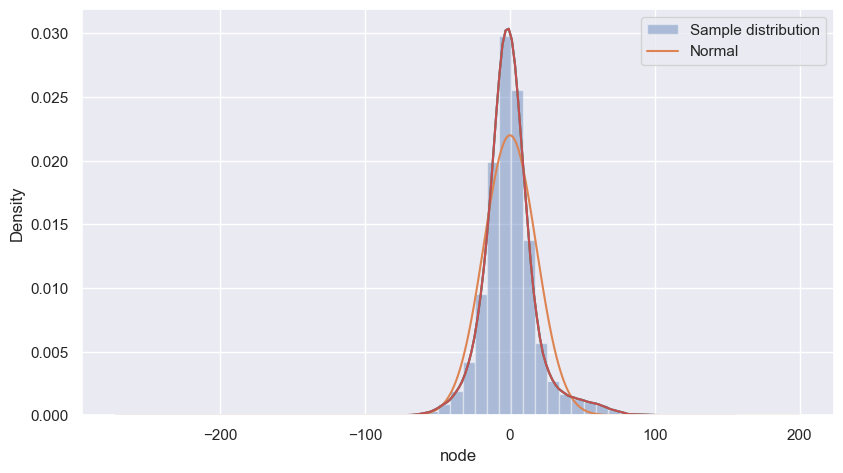

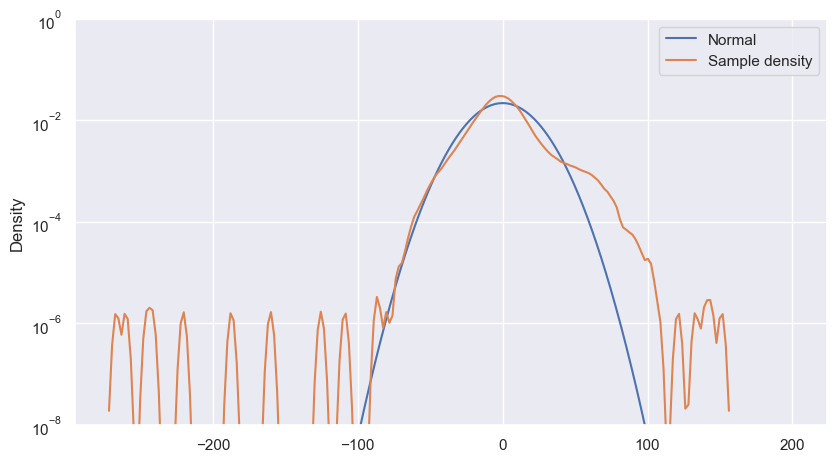

In [141]:
from scipy.stats import norm

x = np.linspace(-200,200,10000)

sns.set(rc={'figure.figsize':(9.7,5.27)})
sns.distplot(Rt, label='Sample distribution')
plt.plot(x, norm.pdf(x, mu_Rt, std_Rt), label='Normal')
plt.legend()

# Density estimation
x_values = sns.kdeplot(Rt).get_lines()[0].get_xdata()
kde_values = sns.kdeplot(Rt).get_lines()[0].get_ydata()

fig, axs = plt.subplots(1,1)
axs.plot(x, norm.pdf(x, mu_Rt, std_Rt), label='Normal')
axs.plot(x_values, kde_values, label='Sample density')
axs.set_ylabel("Density")
axs.set_ylim([10**-8,1])
axs.set_yscale('log')
axs.legend()


## Augmented Dickey-Fuller unit root test

In [142]:
from statsmodels.tsa.stattools import adfuller

res = adfuller(Yt)

print("test statistic: ", res[0])
print("p-value: ", res[1])

test statistic:  -16.442050122870125
p-value:  2.4226400320819765e-29


In [8]:
from statsmodels.tsa.stattools import adfuller

res = adfuller(Xt)

print("test statistic: ", res[0])
print("p-value: ", res[1])

test statistic:  -19.241822417933662
p-value:  0.0


# Group P - Northern Scotland

## 1) Seasonality - Net Load

In [143]:
GroupP_df["node"].describe()

count    138192.000000
mean         40.979303
std         204.185481
min        -633.061000
25%        -100.470500
50%          77.686000
75%         200.094000
max         554.150000
Name: node, dtype: float64

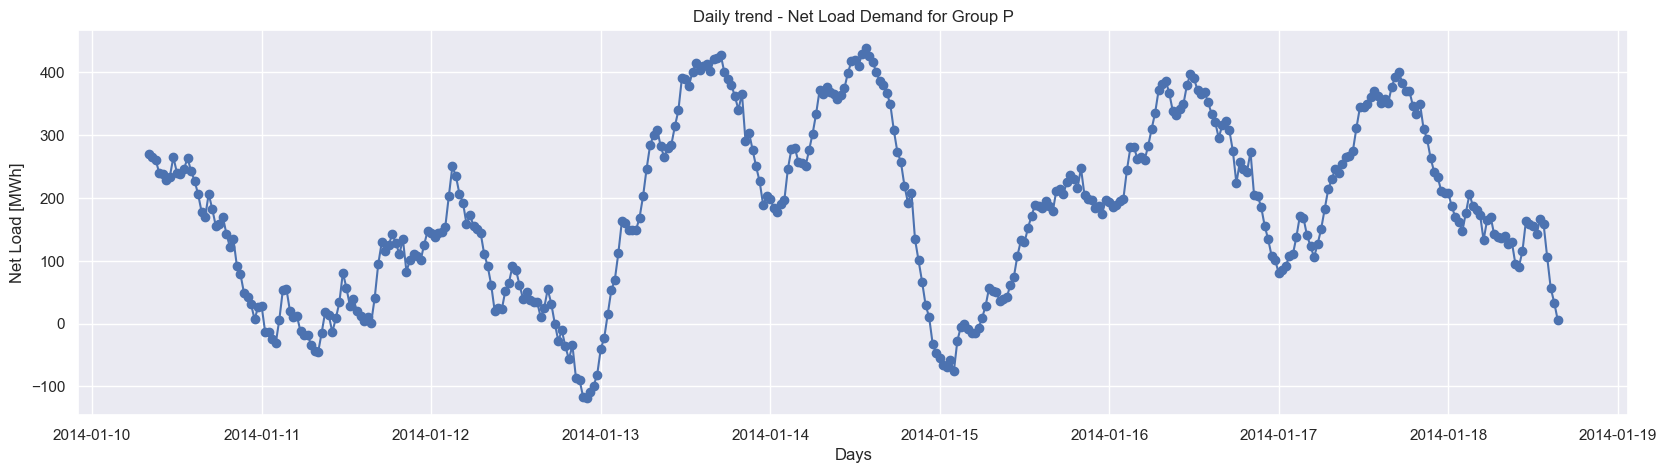

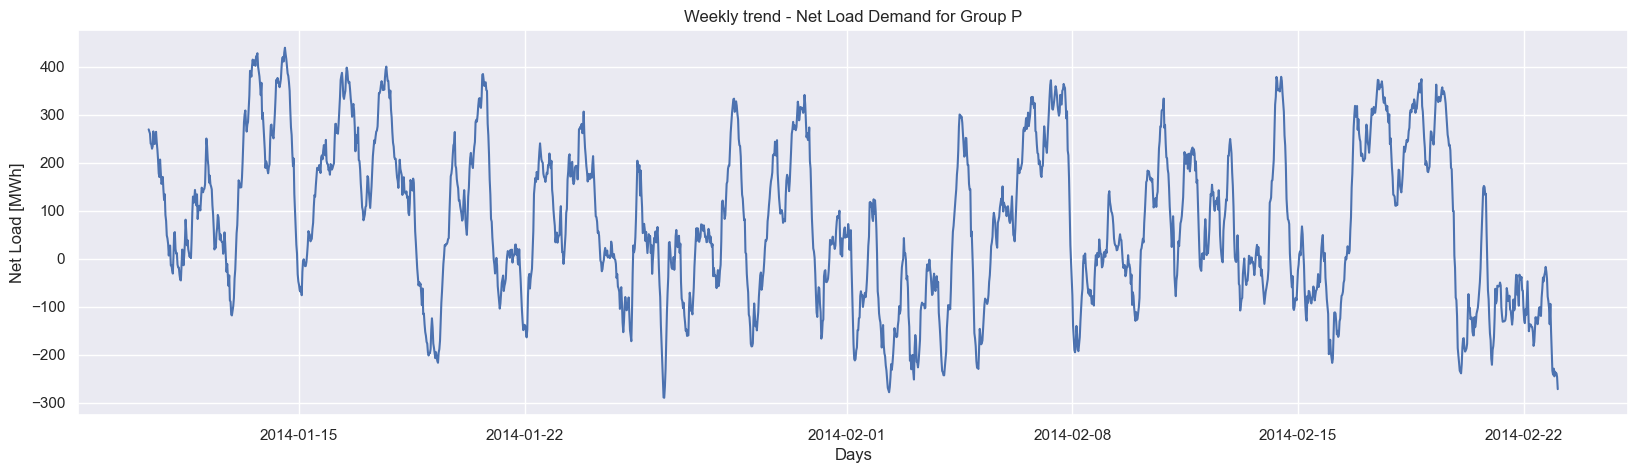

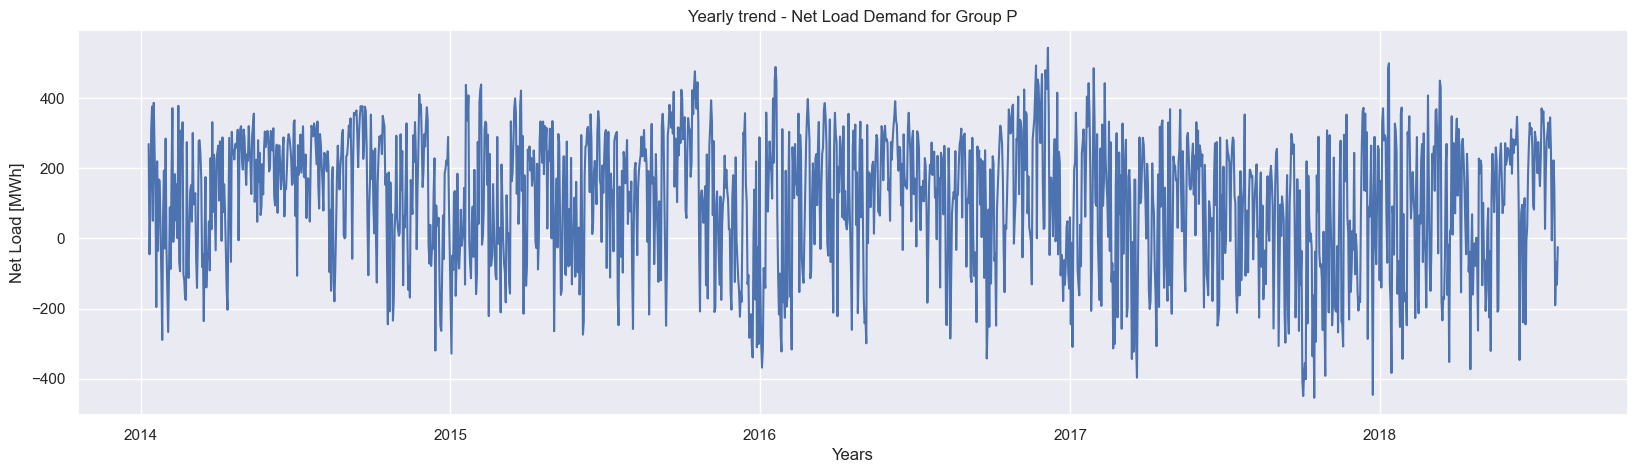

In [144]:
fig, axs = plt.subplots(1,1, figsize=(20,5))
axs.plot(GroupP_df["targetTime"][400:800], GroupP_df["node"][400:800], '-o')
axs.set_title("Daily trend - Net Load Demand for Group P")
axs.set_xlabel("Days");
axs.set_ylabel("Net Load [MWh]");

fig, axs = plt.subplots(1,1, figsize=(20,5))
axs.plot(GroupP_df["targetTime"][400:2500], GroupP_df["node"][400:2500])
axs.set_title("Weekly trend - Net Load Demand for Group P")
axs.set_xlabel("Days");
axs.set_ylabel("Net Load [MWh]");

fig, axs = plt.subplots(1,1, figsize=(20,5))
axs.plot(GroupP_df["targetTime"][400:80000:48], GroupP_df["node"][400:80000:48])
axs.set_title("Yearly trend - Net Load Demand for Group P")
axs.set_xlabel("Years");
axs.set_ylabel("Net Load [MWh]");

We can observe that seasonality is weaker wrt Group C on daily, monthly and yearly basis

## 2) Partial Auto Correlation Function PACF

In [145]:
def Seasonality(t, dow, doy, clock_hour):
    # seasonality on yearly scale
    wy = 2*np.pi/365
    # seasonality on weekly scale: we look for weekend days
    is_saturday = dow == 'Sam'
    is_sunday = dow == 'Dim'
    day_of_week = 1*(dow=='Lun')+2*(dow=='Mar')+3*(dow=='Mer')+4*(dow=='Jeu')+5*(dow=='Ven')+6*(dow=='Sam')+7*(dow=='Dim')
    ww = 2*np.pi/7
    # seasonality on daily scale
    wd = 2*np.pi/24
    
    
    St = np.array([np.ones(doy.shape), t, np.cos(wy*doy), np.sin(wy*doy), is_saturday, is_sunday, np.cos(ww*day_of_week),
                   np.sin(ww*day_of_week), 
                   np.cos(ww*day_of_week)*np.cos(wd*clock_hour), np.sin(ww*day_of_week)*np.sin(wd*clock_hour),
                   np.cos(wd*clock_hour), np.sin(wd*clock_hour), np.cos(wd*clock_hour)*np.sin(wd*clock_hour),
                   np.cos(2*wd*clock_hour), np.sin(2*wd*clock_hour),np.cos(3*wd*clock_hour), 
                   np.sin(3*wd*clock_hour), np.cos(4*wd*clock_hour), np.sin(4*wd*clock_hour)]).T
    return St

In [146]:
# We first want to capture seasonality and then remove it
St = Seasonality(GroupP_df["t"],GroupP_df["dow"], GroupP_df["doy"], GroupP_df["clock_hour"])
Yt = GroupP_df["node"] #Net-Load to predict

model = sm.OLS(Yt, St)
results = model.fit()
params = results.params
print("Parameters: ", results.params)
print("RMSE: ", RMSE(Yt, St@params))

Parameters:  const    134.510927
x1      -169.072410
x2       -61.749846
x3         3.212287
x4       -32.588243
x5       -35.499229
x6         0.686990
x7         7.792024
x8        14.728925
x9         0.405295
x10      -34.323327
x11      -13.838506
x12       -6.508737
x13      -17.968363
x14      -13.017475
x15       -4.077376
x16        1.720659
x17       -1.129904
x18        5.166884
dtype: float64
RMSE:  190.15091584365834


In [147]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   node   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     1244.
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:08:23   Log-Likelihood:            -9.2129e+05
No. Observations:              138192   AIC:                         1.843e+06
Df Residuals:                  138174   BIC:                         1.843e+06
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        134.5109      1.163    115.654      0.000     132.231     136.790
x1          -169.0724      1.780    -94.999      0.000    -172.561    -165.584
x2           -61.7498      0.727    -84.913      0.000     -63.175     -60.325
x3             3.2123      0.723      4.443      0.000       1.795       4.629
x4           -32.5882      2.163    -15.064      0.000     -36.828     -28.348
x5           -35.4992      2.163    -16.412      0.000     -39.739     -31.260
x6             0.6870      1.149      0.598      0.550      -1.565       2.939
x7             7.7920      0.871      8.948      0.000       6.085       9.499
x8            14.7289      1.023     14.400      0.000      12.724      16.734
x9             0.4053      1.024      0.396      0.692      -1.601       2.411
x10          -34.3233      0.723    -47.442      0.000     -35.741     -32.905
x11          -13.8385      0.723    -19.130      0.000     -15.256     -12.421
x12           -6.5087      0.289    -22.493      0.000      -7.076      -5.942
x13          -17.9684      0.723    -24.837      0.000     -19.386     -16.550
x14          -13.0175      0.579    -22.493      0.000     -14.152     -11.883
x15           -4.0774      0.723     -5.636      0.000      -5.495      -2.659
x16            1.7207      0.723      2.378      0.017       0.303       3.139
x17           -1.1299      0.723     -1.562      0.118      -2.548       0.288
x18            5.1669      0.723      7.142      0.000       3.749       6.585
==============================================================================
Omnibus:                     5083.438   Durbin-Watson:                   0.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3988.062
Skew:                          -0.332   Prob(JB):                         0.00
Kurtosis:                       2.498   Cond. No.                     1.51e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is  8e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

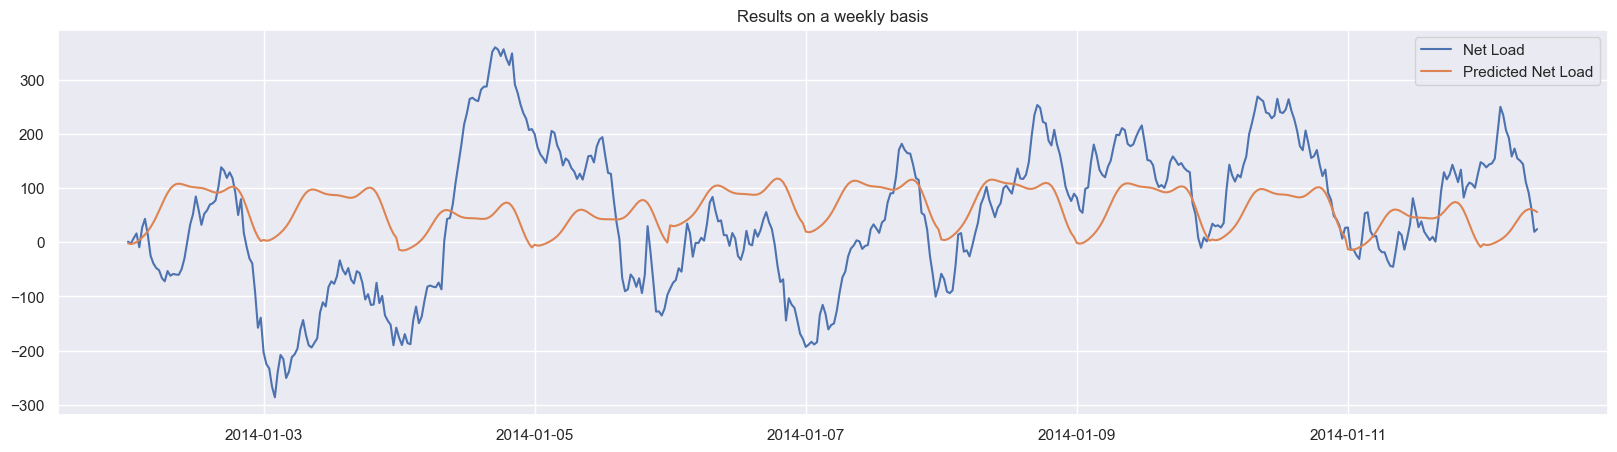

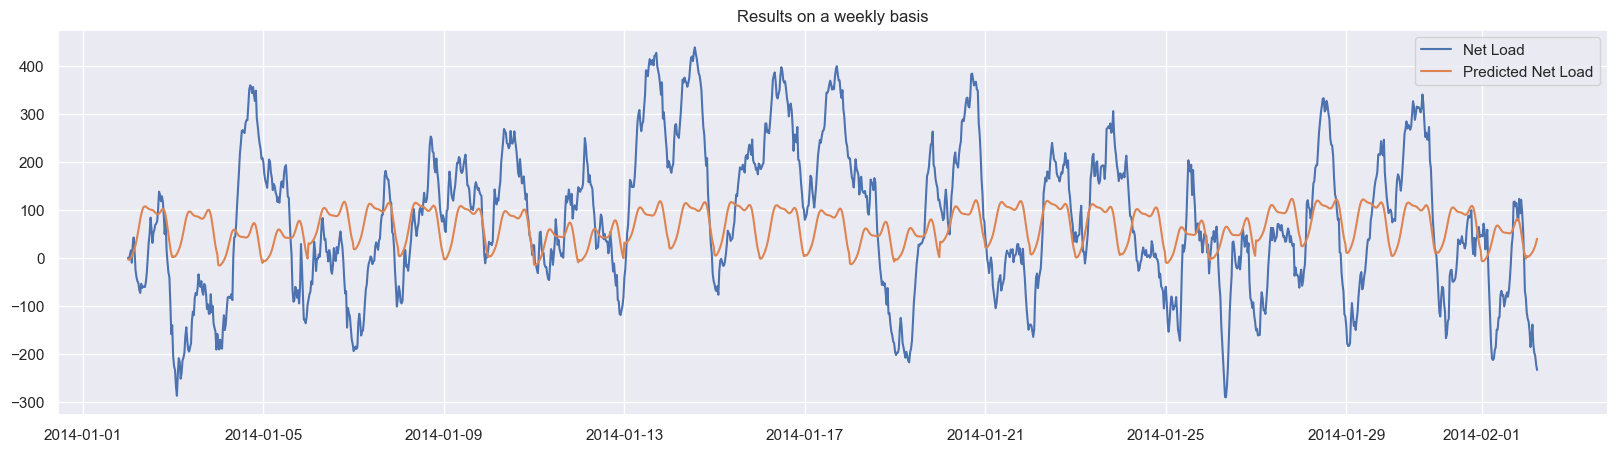

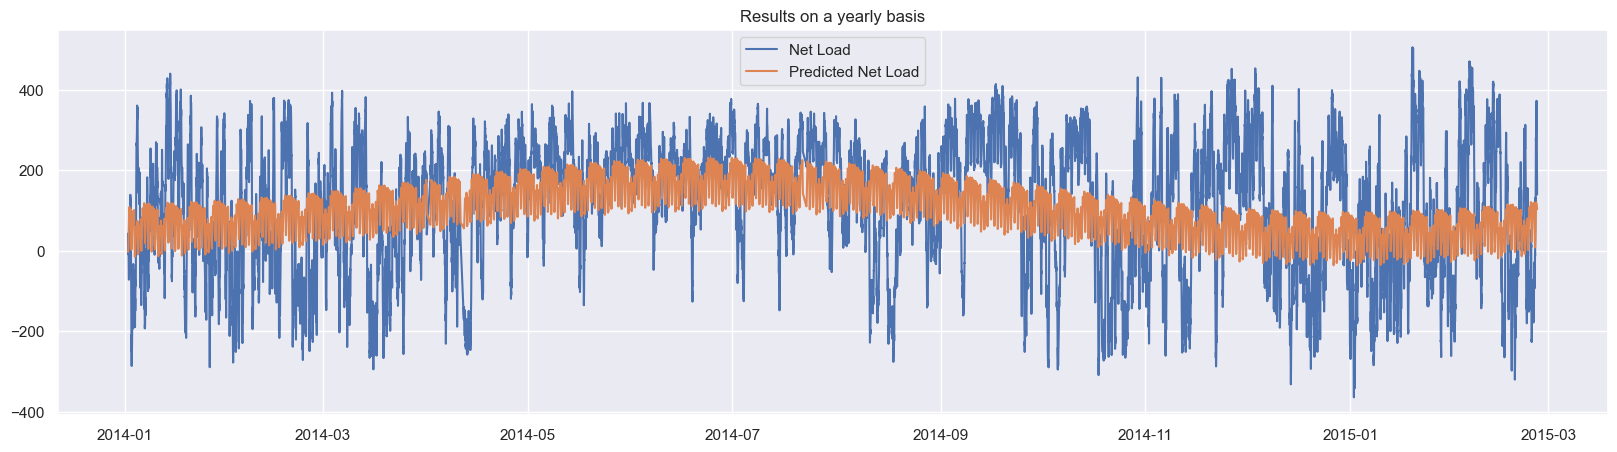

In [148]:
fig, axs = plt.subplots(1,1,figsize=(20,5))
axs.plot(GroupP_df["targetTime"][:500],Yt[:500], label='Net Load')
axs.plot(GroupP_df["targetTime"][:500],(St@params)[:500], label='Predicted Net Load')
axs.set_title('Results on a weekly basis')
axs.legend()

fig, axs = plt.subplots(1,1,figsize=(20,5))
axs.plot(GroupP_df["targetTime"][:1500],Yt[:1500], label='Net Load')
axs.plot(GroupP_df["targetTime"][:1500],(St@params)[:1500], label='Predicted Net Load')
axs.set_title('Results on a weekly basis')
axs.legend()

fig, axs = plt.subplots(1,1,figsize=(20,5))
axs.plot(GroupP_df["targetTime"][:20000],Yt[:20000], label='Net Load')
axs.plot(GroupP_df["targetTime"][:20000],(St@params)[:20000], label='Predicted Net Load')
axs.set_title('Results on a yearly basis')
axs.legend();


### Deseasonalizing process
We define Xt := Yt - St to deseasonalize

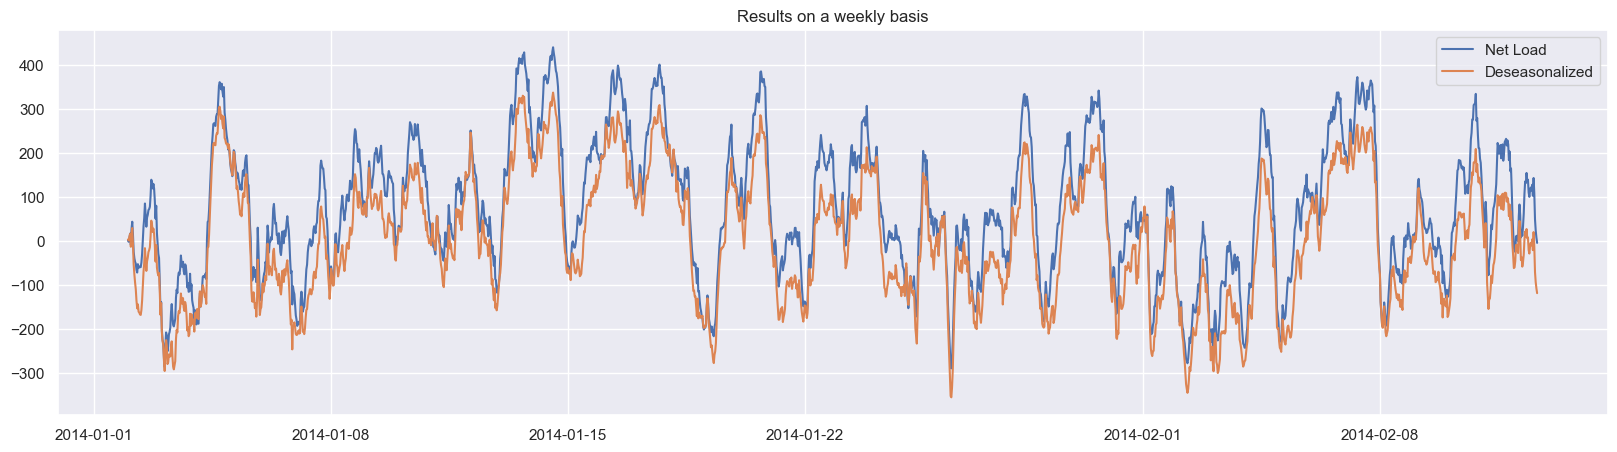

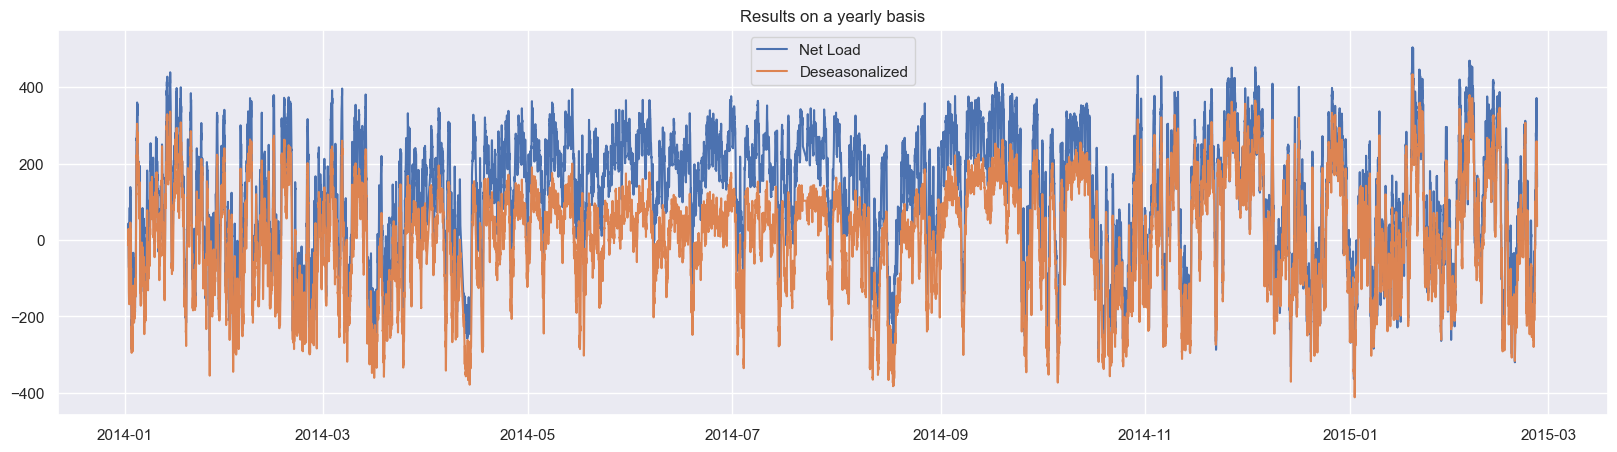

In [149]:
Xt = Yt - St@params
fig, axs = plt.subplots(1,1,figsize=(20,5))
axs.plot(GroupC_df["targetTime"][:2000],Yt[:2000], label='Net Load')
axs.plot(GroupC_df["targetTime"][:2000],Xt[:2000], label='Deseasonalized')
axs.set_title('Results on a weekly basis')
axs.legend()

fig, axs = plt.subplots(1,1,figsize=(20,5))
axs.plot(GroupC_df["targetTime"][:20000],Yt[:20000], label='Net Load')
axs.plot(GroupC_df["targetTime"][:20000],Xt[:20000], label='Deseasonalized')
axs.set_title('Results on a yearly basis')
axs.legend();

C:\Users\Utente\AppData\Local\Temp\ipykernel_9068\2030097459.py:2: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(range(400), acf(Xt, nlags=399), 'o')
C:\Users\Utente\AppData\Local\Temp\ipykernel_9068\2030097459.py:9: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(range(400), pacf(Xt, nlags=399), 'o')


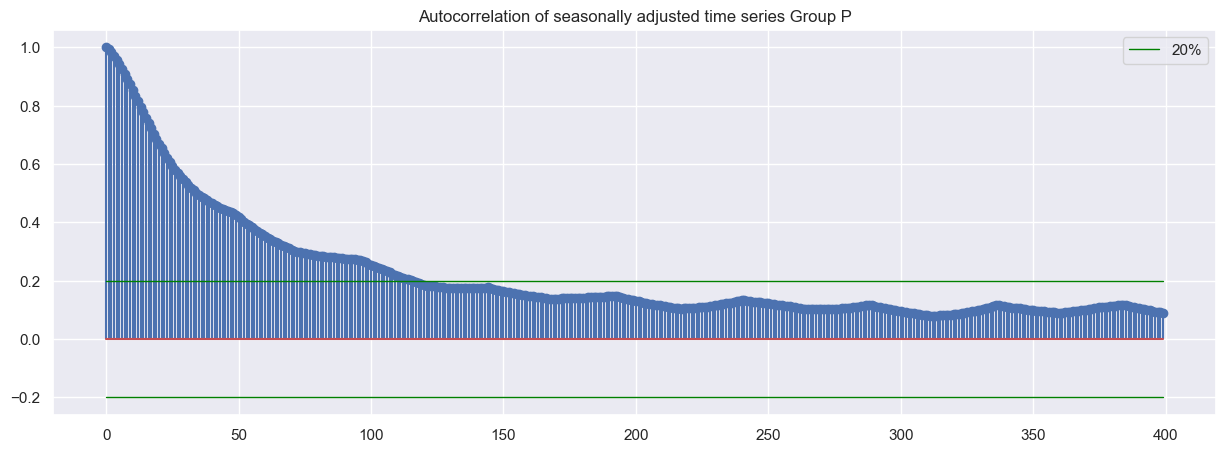

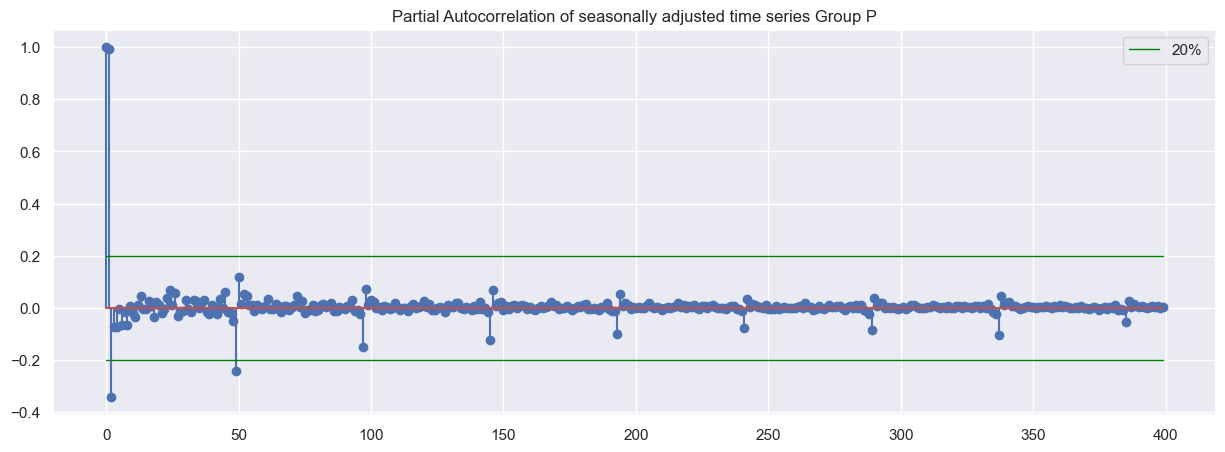

In [150]:
fig, axs = plt.subplots(1,1,figsize=(15,5))
plt.stem(range(400), acf(Xt, nlags=399), 'o')
plt.plot(range(400), 0.2*np.ones(400,), color='green', linewidth=1, label='20%')
plt.plot(range(400), -0.2*np.ones(400,), color='green', linewidth=1)
plt.title('Autocorrelation of seasonally adjusted time series Group P');
plt.legend()

fig, axs = plt.subplots(1,1,figsize=(15,5))
plt.stem(range(400), pacf(Xt, nlags=399), 'o')
plt.plot(range(400), 0.2*np.ones(400,), color='green', linewidth=1, label='20%')
plt.plot(range(400), -0.2*np.ones(400,), color='green', linewidth=1)
plt.title('Partial Autocorrelation of seasonally adjusted time series Group P');
plt.legend()

The Partial Autocorrelation plot suggests to introduce three AR terms: lag 1, lag 2, lag 48 (daily) 

Yt = params*St + beta1 * Y(t-1) + beta2 * Y(t-2) + beta3 * Y(t-48)  + Rt


In [151]:
Yt_AR = GroupP_df["node"].iloc[336:]
St_AR = Seasonality(GroupP_df["t"].iloc[336:],GroupP_df["dow"].iloc[336:], GroupP_df["doy"].iloc[336:], GroupP_df["clock_hour"].iloc[336:])
features = np.c_[St_AR, GroupP_df["node"].iloc[336-1:-1], GroupP_df["node"].iloc[336-2:-2],
                GroupP_df["node"].iloc[336-48:-48]]

model = sm.OLS(Yt_AR, features)
results = model.fit()
params = results.params
print("Parameters: ", results.params)
print("RMSE: ", RMSE(Yt_AR, features@params))

Parameters:  const    0.962625
x1      -1.259915
x2      -0.456879
x3       0.047810
x4      -0.033074
x5      -0.207522
x6      -0.024138
x7       0.081207
x8      -0.288252
x9       0.834260
x10     -1.398593
x11      2.793223
x12      1.194492
x13     -2.915776
x14      2.388985
x15      0.421892
x16      1.089410
x17      1.884311
x18      0.479007
x19      1.342451
x20     -0.350975
x21      0.001076
dtype: float64
RMSE:  19.506744554926087


In [152]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   node   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 7.492e+05
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:09:17   Log-Likelihood:            -6.0515e+05
No. Observations:              137856   AIC:                         1.210e+06
Df Residuals:                  137835   BIC:                         1.211e+06
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9626      0.127      7.575      0.000       0.714       1.212
x1            -1.2599      0.191     -6.583      0.000      -1.635      -0.885
x2            -0.4569      0.077     -5.901      0.000      -0.609      -0.305
x3             0.0478      0.074      0.645      0.519      -0.098       0.193
x4            -0.0331      0.223     -0.149      0.882      -0.469       0.403
x5            -0.2075      0.222     -0.933      0.351      -0.643       0.228
x6            -0.0241      0.118     -0.204      0.838      -0.256       0.208
x7             0.0812      0.089      0.908      0.364      -0.094       0.257
x8            -0.2883      0.105     -2.740      0.006      -0.494      -0.082
x9             0.8343      0.105      7.932      0.000       0.628       1.040
x10           -1.3986      0.075    -18.555      0.000      -1.546      -1.251
x11            2.7932      0.075     37.139      0.000       2.646       2.941
x12            1.1945      0.030     39.880      0.000       1.136       1.253
x13           -2.9158      0.076    -38.423      0.000      -3.065      -2.767
x14            2.3890      0.060     39.880      0.000       2.272       2.506
x15            0.4219      0.074      5.677      0.000       0.276       0.568
x16            1.0894      0.074     14.636      0.000       0.944       1.235
x17            1.8843      0.074     25.325      0.000       1.738       2.030
x18            0.4790      0.075      6.425      0.000       0.333       0.625
x19            1.3425      0.003    532.197      0.000       1.338       1.347
x20           -0.3510      0.003   -138.885      0.000      -0.356      -0.346
x21            0.0011      0.000      3.504      0.000       0.000       0.002
==============================================================================
Omnibus:                     6313.016   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21792.181
Skew:                          -0.082   Prob(JB):                         0.00
Kurtosis:                       4.941   Cond. No.                     4.39e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.44e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Impact of Autoregressive term

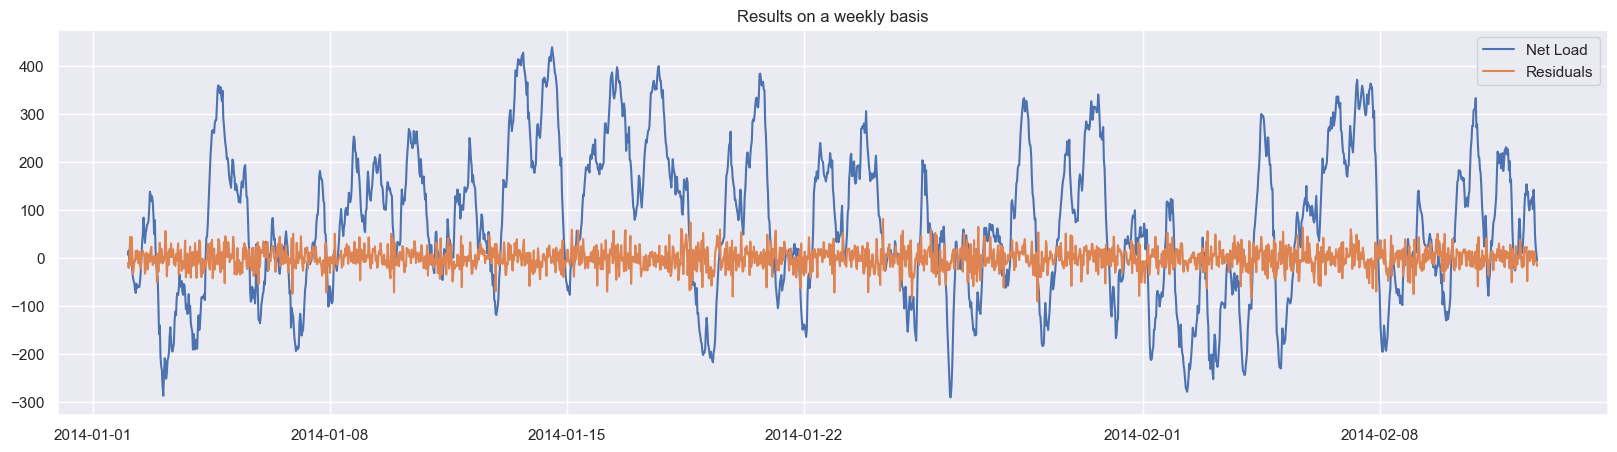

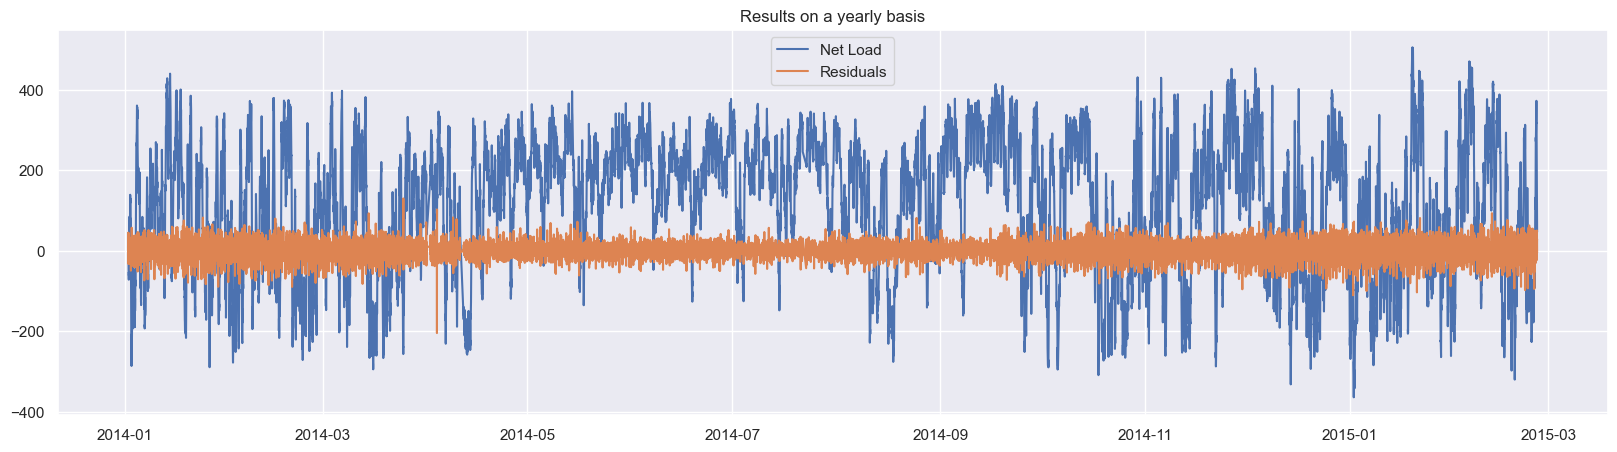

In [153]:
# Residuals
Rt = Yt_AR - features@params
fig, axs = plt.subplots(1,1,figsize=(20,5))
axs.plot(GroupP_df["targetTime"][2:2000],Yt[2:2000], label='Net Load')
axs.plot(GroupP_df["targetTime"][2:2000],Rt[:1998], label='Residuals')
axs.set_title('Results on a weekly basis')
axs.legend()

fig, axs = plt.subplots(1,1,figsize=(20,5))
axs.plot(GroupP_df["targetTime"][2:20002],Yt[2:20002], label='Net Load')
axs.plot(GroupP_df["targetTime"][2:20002],Rt[:20000], label='Residuals')
axs.set_title('Results on a yearly basis')
axs.legend();

## 3) Residuals Distribution (after having deseasonalized and removed AR terms) 

Residuals distribution after having deseasonalized and removed the AR(1), AR(2), AR(48), AR(336) terms

In [154]:
mu_Rt = Rt.mean()
std_Rt = Rt.std()

C:\Users\Utente\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


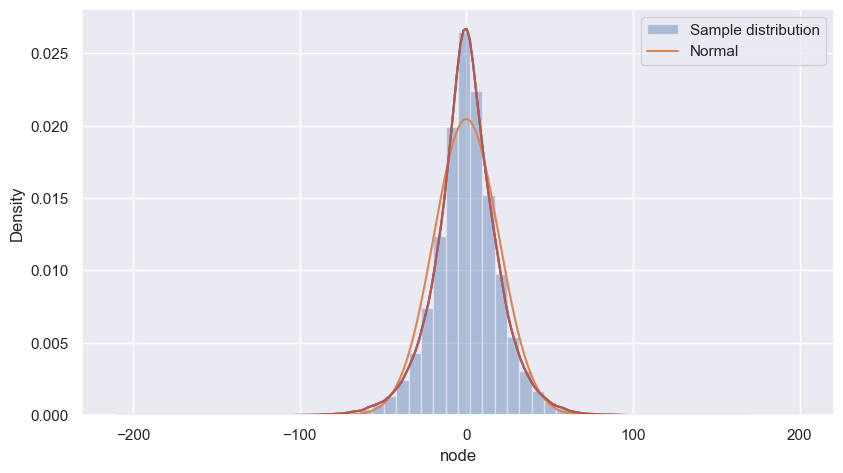

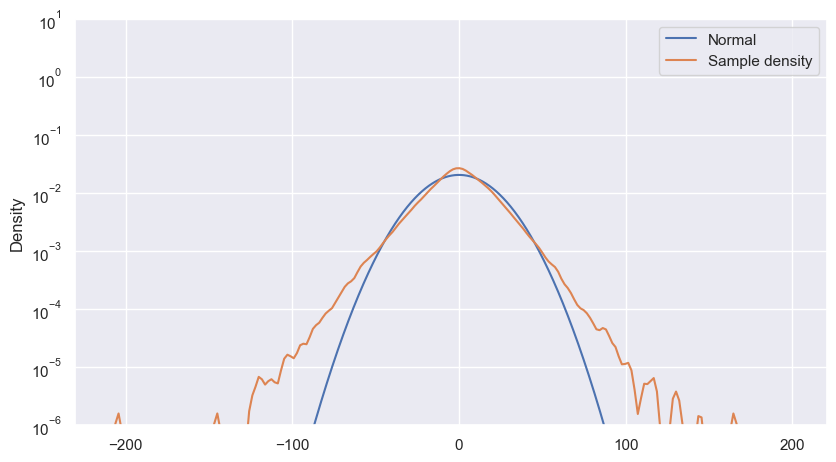

In [155]:
from scipy.stats import norm

x = np.linspace(-200,200,10000)

sns.set(rc={'figure.figsize':(9.7,5.27)})
sns.distplot(Rt, label='Sample distribution')
plt.plot(x, norm.pdf(x, mu_Rt, std_Rt), label='Normal')
plt.legend()

# Density estimation
x_values = sns.kdeplot(Rt).get_lines()[0].get_xdata()
kde_values = sns.kdeplot(Rt).get_lines()[0].get_ydata()

fig, axs = plt.subplots(1,1)
axs.plot(x, norm.pdf(x, mu_Rt, std_Rt), label='Normal')
axs.plot(x_values, kde_values, label='Sample density')
axs.set_ylabel("Density")
axs.set_yscale('log')
axs.set_ylim([1e-6, 10])
axs.legend()


## Augmented Dickey-Fuller unit root test

In [156]:
res = adfuller(Yt)

print("test statistic: ", res[0])
print("p-value: ", res[1])

test statistic:  -22.72744009089361
p-value:  0.0


# Importing solar generation data for Groups C and P 

In [157]:
# Solar Generation
solar_gsp_groups = pyreadr.read_r(home + '\\Other_data\\solar_gsp_group_v2.Rda')
solar_gsp_groups_df = pd.DataFrame(list(solar_gsp_groups.values())[0])
solar_gsp_groupC_df = solar_gsp_groups_df.loc[solar_gsp_groups_df["gsp_group"] =="_C"].sort_values(by='datetime_gmt').dropna().reset_index(drop=True)
solar_gsp_groupP_df = solar_gsp_groups_df.loc[solar_gsp_groups_df["gsp_group"] =="_P"].sort_values(by='datetime_gmt').dropna().reset_index(drop=True)

In [158]:
solar_gsp_groupP_df

datetime_gmt gsp_group  generation_mw  capacity_mwp  \
0      2014-01-01 00:30:00        _P            0.0     67.519396   
1      2014-01-01 01:00:00        _P            0.0     67.519396   
2      2014-01-01 01:30:00        _P            0.0     67.519396   
3      2014-01-01 02:00:00        _P            0.0     67.519396   
4      2014-01-01 02:30:00        _P            0.0     67.519396   
...                    ...       ...            ...           ...   
139724 2021-12-31 21:30:00        _P            0.0    178.453603   
139725 2021-12-31 22:00:00        _P            0.0    178.453603   
139726 2021-12-31 22:30:00        _P            0.0    178.453603   
139727 2021-12-31 23:00:00        _P            0.0    178.453603   
139728 2021-12-31 23:30:00        _P            0.0    178.453603   

        installedcapacity_mwp  
0                   68.415641  
1                   68.415641  
2                   68.415641  
3                   68.415641  
4                   68.415641  
...                       ...  
139724             189.471242  
139725             189.471242  
139726             189.471242  
139727             189.471242  
139728             189.471242  

[139729 rows x 5 columns]

In [159]:
def dataset_preprocessing_solar(df):
    df['t'] = df.index/len(df)
    df['dow'] = df['datetime_gmt'].dt.day_name()
    df['doy'] = df['datetime_gmt'].dt.dayofyear
    df['clock_hour'] = df['datetime_gmt'].dt.hour + df['datetime_gmt'].dt.minute / 60

dataset_preprocessing_solar(solar_gsp_groupC_df)
dataset_preprocessing_solar(solar_gsp_groupP_df)

# Solar Production Group C

## 1) Seasonality 

In [160]:
solar_gsp_groupC_df["generation_mw"].describe()

count    139729.000000
mean          5.395320
std           9.220233
min           0.000000
25%           0.000000
50%           0.012214
75%           7.154143
max          49.851610
Name: generation_mw, dtype: float64

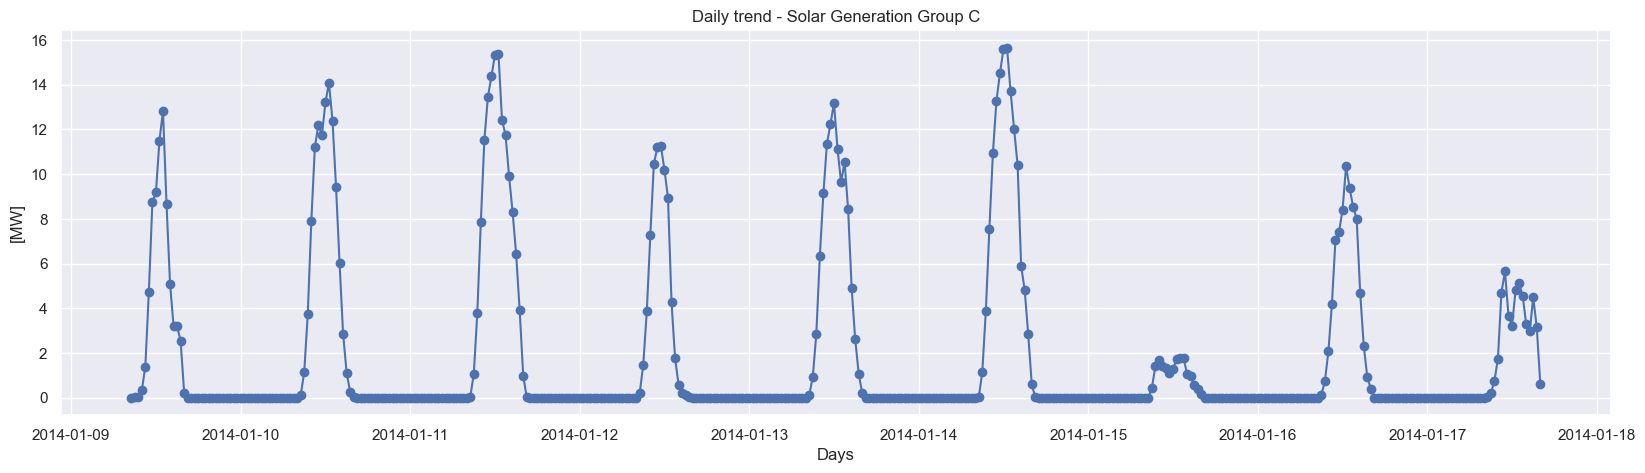

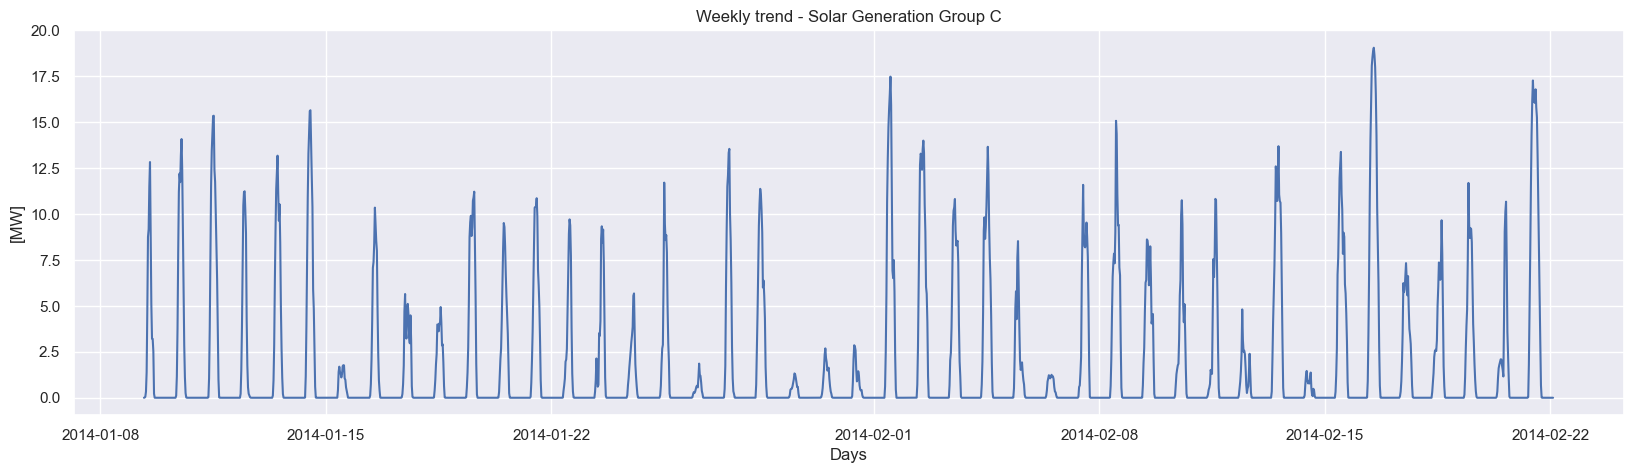

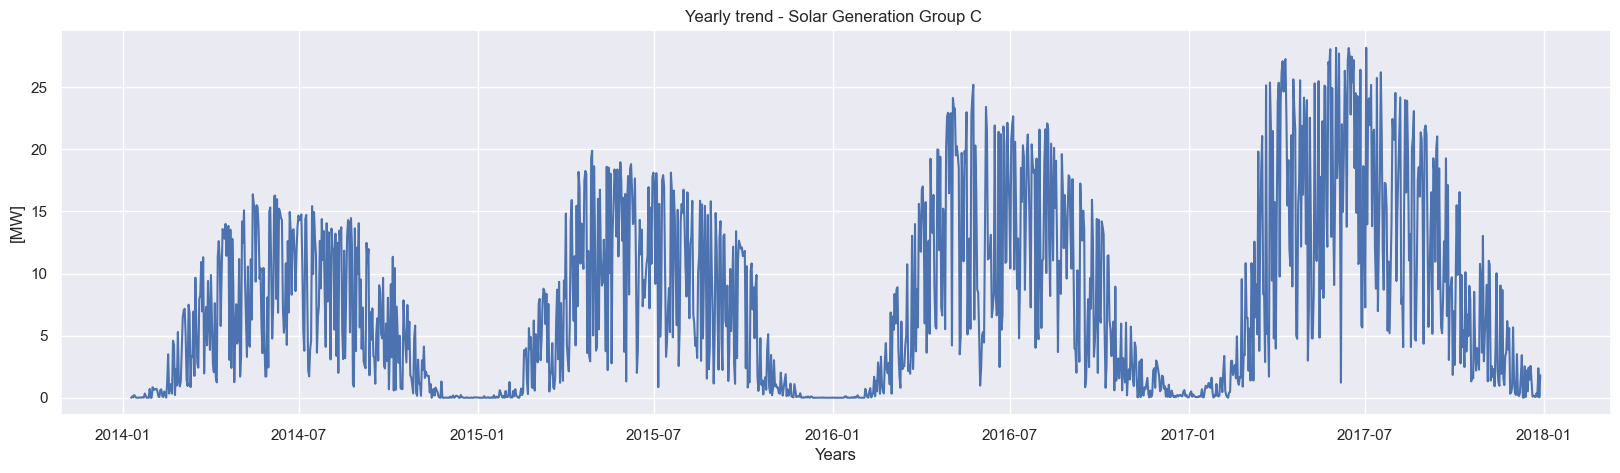

In [161]:
fig, axs = plt.subplots(1,1, figsize=(20,5))
axs.plot(solar_gsp_groupC_df['datetime_gmt'][400:800], solar_gsp_groupC_df['generation_mw'][400:800], '-o')
axs.set_title("Daily trend - Solar Generation Group C")
axs.set_xlabel("Days");
axs.set_ylabel("[MW]");

fig, axs = plt.subplots(1,1, figsize=(20,5))
axs.plot(solar_gsp_groupC_df['datetime_gmt'][400:2500], solar_gsp_groupC_df['generation_mw'][400:2500])
axs.set_title("Weekly trend - Solar Generation Group C")
axs.set_xlabel("Days");
axs.set_ylabel("[MW]");

fig, axs = plt.subplots(1,1, figsize=(20,5))
axs.plot(solar_gsp_groupC_df['datetime_gmt'][400:70000:48], solar_gsp_groupC_df['generation_mw'][400:70000:48])
axs.set_title("Yearly trend - Solar Generation Group C ")
axs.set_xlabel("Years");
axs.set_ylabel("[MW]");

## 2) Partial Auto Correlation Function PACF

In [162]:
def Seasonality_Components_Solar(t, dow, doy, clock_hour, datetime):
    # seasonality on yearly scale
    wy = 2*np.pi/365
    month = datetime.dt.month
    is_summer = (month > 5)*(month < 9)
    # seasonality on weekly scale: we look for weekend days
    is_saturday = dow == 'Saturday'
    is_sunday = dow == 'Sunday'
    day_of_week = 1*(dow=='Monday')+2*(dow=='Tuesday')+3*(dow=='Wednesday')+4*(dow=='Thursday')+5*(dow=='Friday') \
                +6*(dow=='Saturday')+7*(dow=='Sunday')
    ww = 2*np.pi/7
    # seasonality on daily scale
    wd = 2*np.pi/48
    daily_hours = 1*(clock_hour < 36)*(clock_hour > 12) #between 6am and 6pm
    
    
    St = np.array([np.ones(doy.shape), t*daily_hours, np.cos(wy*doy)*daily_hours, np.sin(wy*doy)*daily_hours,
                   np.cos(wy*doy)*is_summer*daily_hours, np.sin(wy*doy)*is_summer*daily_hours, 
                   is_saturday, is_sunday, np.cos(ww*day_of_week)*daily_hours,np.sin(ww*day_of_week)*daily_hours, daily_hours,
                   np.cos(wd*clock_hour)*daily_hours, np.sin(wd*clock_hour)*daily_hours, np.cos(wd*clock_hour)*np.sin(wd*clock_hour)*daily_hours,
                   np.cos(2*wy*clock_hour), np.sin(2*wy*clock_hour),
                   np.cos(2*wd*clock_hour), np.sin(2*wd*clock_hour)]).T
    return St

### Trend and Seasonality Description

In [163]:
St = Seasonality_Components_Solar(solar_gsp_groupC_df["t"],solar_gsp_groupC_df["dow"], solar_gsp_groupC_df["doy"], solar_gsp_groupC_df["clock_hour"], solar_gsp_groupC_df["datetime_gmt"])
Yt = solar_gsp_groupC_df['generation_mw'] #Target to predict

model = sm.OLS(Yt, St)
results = model.fit()
params = results.params
print("Parameters: ", results.params)
print("RMSE: ", RMSE(Yt, St@params))

Parameters:  const   -215.207961
x1         2.261843
x2        -4.077289
x3         1.060755
x4         0.699957
x5        -0.348927
x6        -0.352271
x7        -0.003916
x8         0.045773
x9        -0.053429
x10     -147.145120
x11     -157.094417
x12      145.008076
x13      174.172060
x14      219.513072
x15       76.557958
x16       -3.205126
x17      -13.641902
dtype: float64
RMSE:  6.0676014148969974


In [164]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          generation_mw   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                 1.076e+04
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:10:01   Log-Likelihood:            -4.5019e+05
No. Observations:              139729   AIC:                         9.004e+05
Df Residuals:                  139711   BIC:                         9.006e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -215.2080     21.674     -9.929      0.000    -257.688    -172.727
x1             2.2618      0.082     27.704      0.000       2.102       2.422
x2            -4.0773      0.048    -84.181      0.000      -4.172      -3.982
x3             1.0608      0.036     29.317      0.000       0.990       1.132
x4             0.7000      0.091      7.711      0.000       0.522       0.878
x5            -0.3489      0.113     -3.097      0.002      -0.570      -0.128
x6            -0.3523      0.053     -6.590      0.000      -0.457      -0.247
x7            -0.0039      0.053     -0.073      0.942      -0.109       0.101
x8             0.0458      0.039      1.176      0.240      -0.031       0.122
x9            -0.0534      0.035     -1.516      0.130      -0.123       0.016
x10         -147.1451      6.462    -22.772      0.000    -159.810    -134.480
x11         -157.0944      5.452    -28.812      0.000    -167.781    -146.408
x12          145.0081      6.315     22.961      0.000     132.630     157.386
x13          174.1721      4.363     39.924      0.000     165.621     182.723
x14          219.5131     21.765     10.086      0.000     176.855     262.171
x15           76.5580      4.219     18.148      0.000      68.290      84.826
x16           -3.2051      0.239    -13.386      0.000      -3.674      -2.736
x17          -13.6419      0.467    -29.242      0.000     -14.556     -12.728
==============================================================================
Omnibus:                    22511.551   Durbin-Watson:                   0.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            65680.943
Skew:                           0.857   Prob(JB):                         0.00
Kurtosis:                       5.889   Cond. No.                     3.16e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

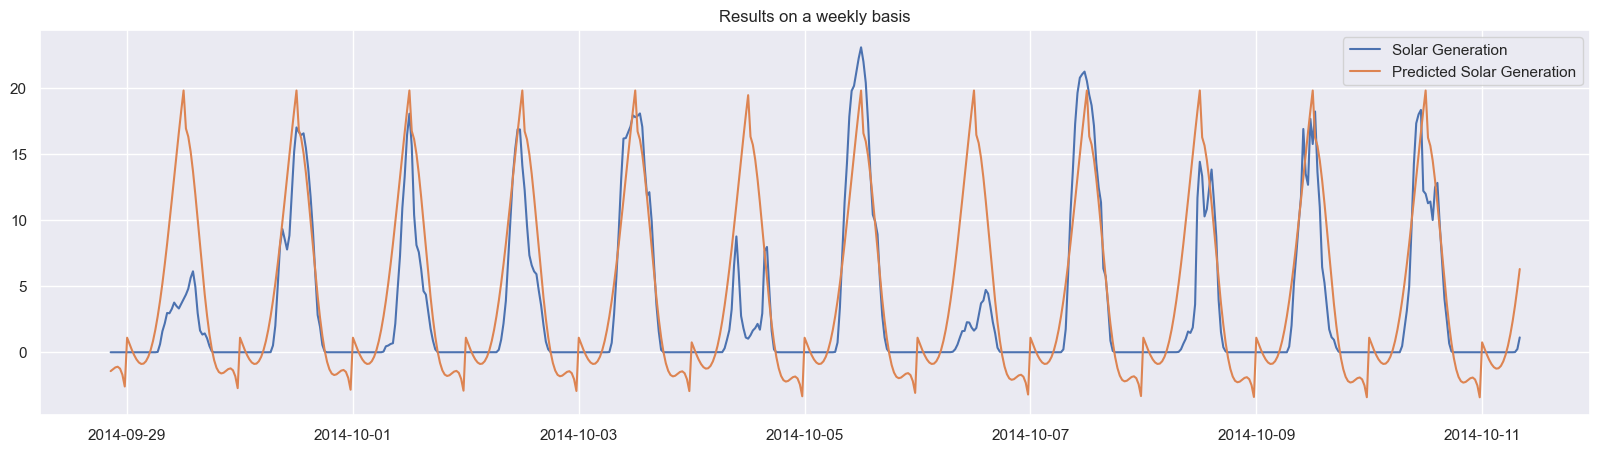

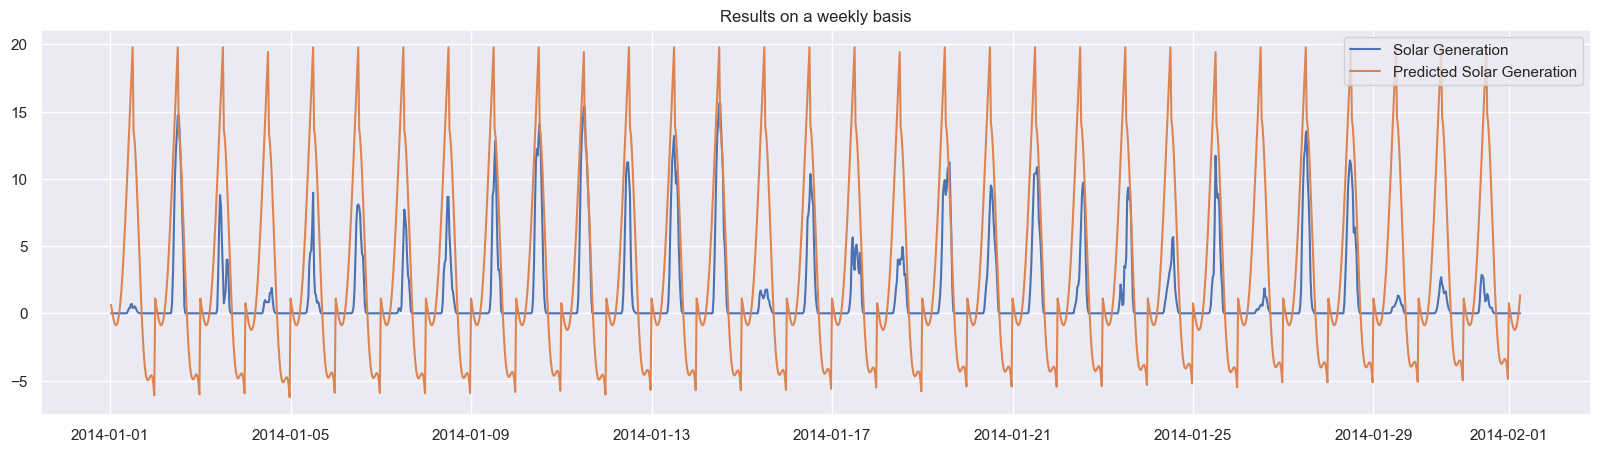

In [165]:
fig, axs = plt.subplots(1,1,figsize=(20,5))
axs.plot(solar_gsp_groupC_df["datetime_gmt"][13000:13600],Yt[13000:13600], label='Solar Generation')
axs.plot(solar_gsp_groupC_df["datetime_gmt"][13000:13600],(St@params)[13000:13600], label='Predicted Solar Generation')
axs.set_title('Results on a weekly basis')
axs.legend()

fig, axs = plt.subplots(1,1,figsize=(20,5))
axs.plot(solar_gsp_groupC_df["datetime_gmt"][:1500],Yt[:1500], label='Solar Generation')
axs.plot(solar_gsp_groupC_df["datetime_gmt"][:1500],(St@params)[:1500], label='Predicted Solar Generation')
axs.set_title('Results on a weekly basis')
axs.legend()



### Deseasonalizing process
We define Xt := Yt - St 

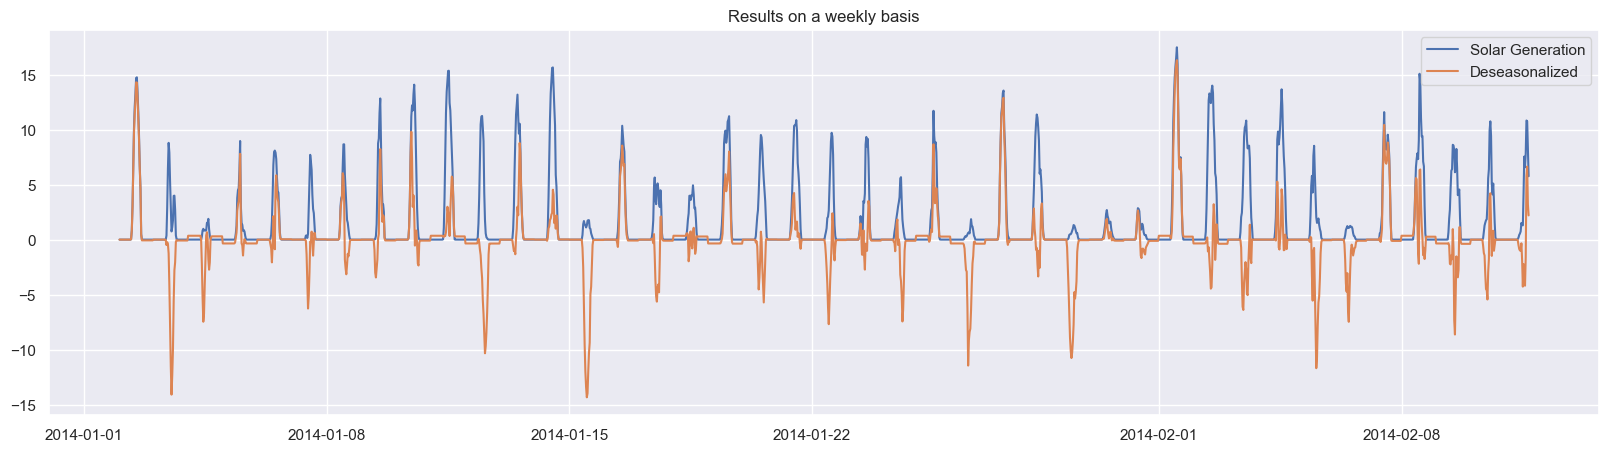

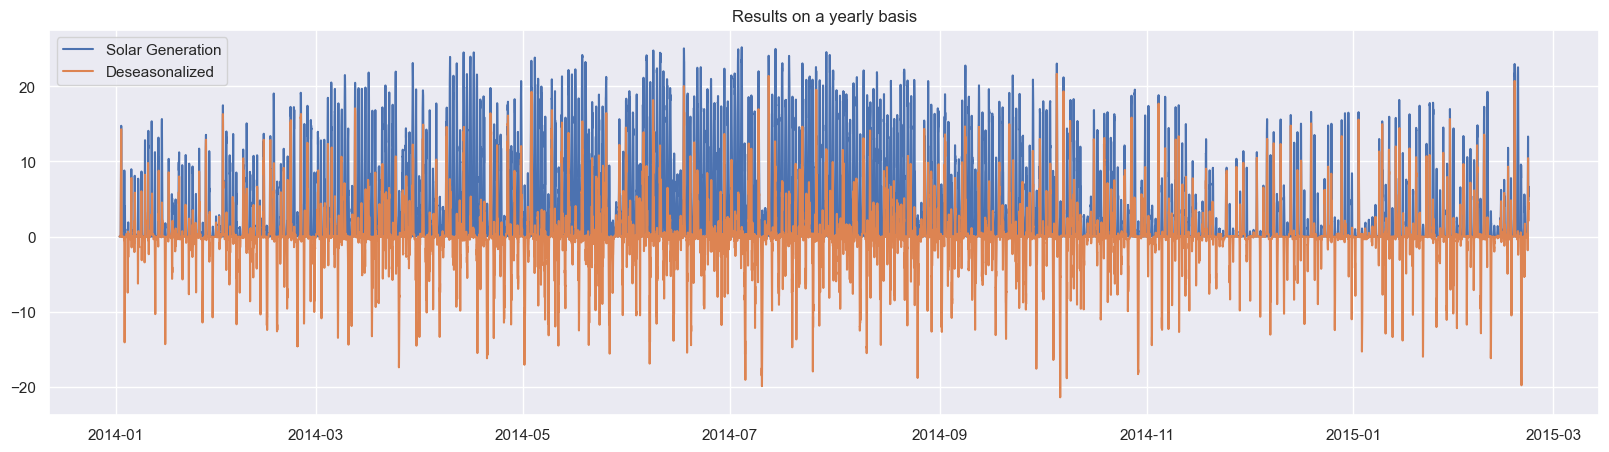

In [166]:
Xt = np.array((Yt - St@params)[48:]) - np.array((Yt - St@params)[:-48]) 
fig, axs = plt.subplots(1,1,figsize=(20,5))
axs.plot(solar_gsp_groupC_df["datetime_gmt"][48:2000],Yt[48:2000], label='Solar Generation')
axs.plot(solar_gsp_groupC_df["datetime_gmt"][48:2000],Xt[:2000-48], label='Deseasonalized')
axs.set_title('Results on a weekly basis')
axs.legend()

fig, axs = plt.subplots(1,1,figsize=(20,5))
axs.plot(solar_gsp_groupC_df["datetime_gmt"][48:20000],Yt[48:20000], label='Solar Generation')
axs.plot(solar_gsp_groupC_df["datetime_gmt"][48:20000],Xt[:20000-48], label='Deseasonalized')
axs.set_title('Results on a yearly basis')
axs.legend();

C:\Users\Utente\AppData\Local\Temp\ipykernel_9068\3153571102.py:4: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(range(400), acf(Xt, nlags=399), 'o')
C:\Users\Utente\AppData\Local\Temp\ipykernel_9068\3153571102.py:11: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(range(400), pacf(Xt, nlags=399), 'o')


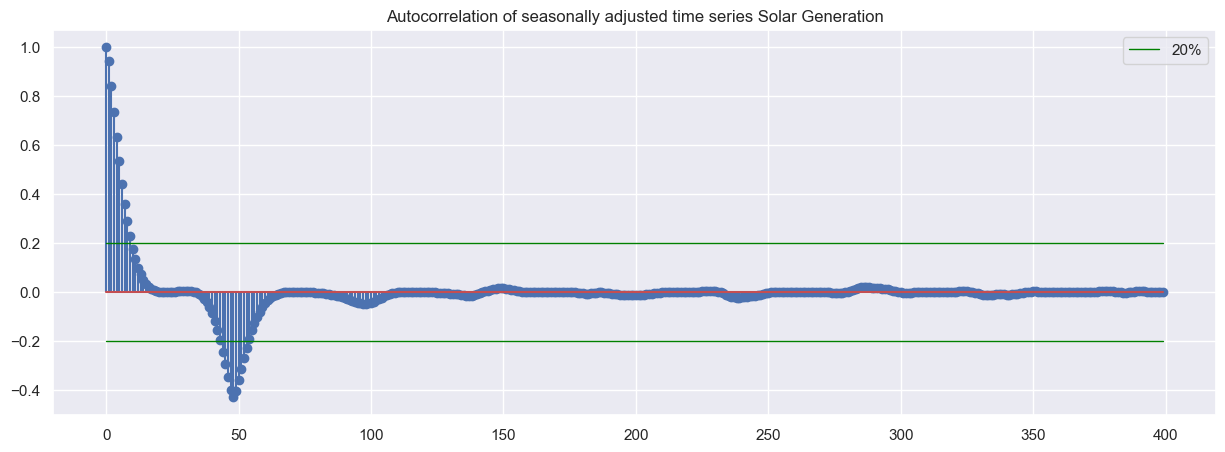

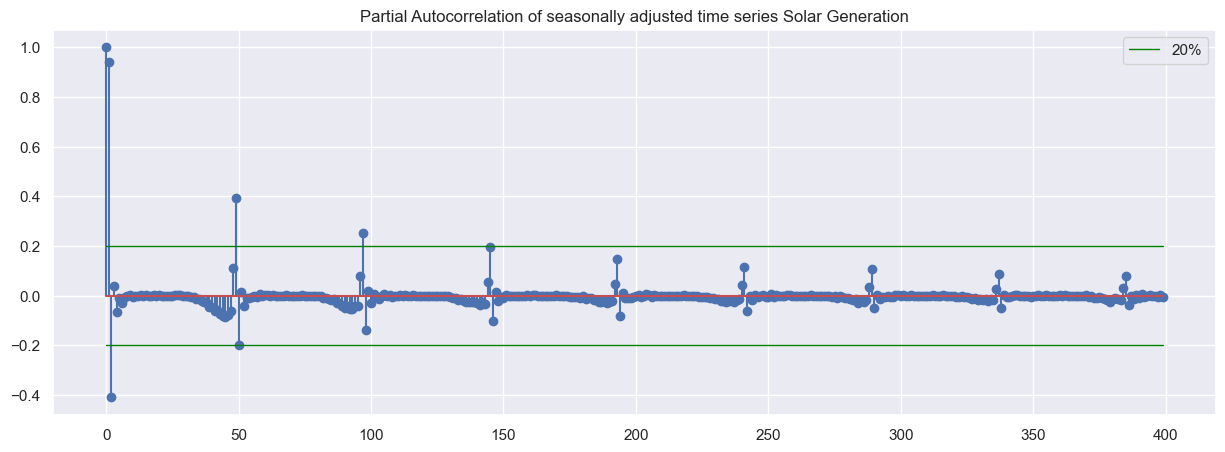

In [167]:
from statsmodels.tsa.stattools import pacf, acf

fig, axs = plt.subplots(1,1,figsize=(15,5))
plt.stem(range(400), acf(Xt, nlags=399), 'o')
plt.plot(range(400), 0.2*np.ones(400,), color='green', linewidth=1, label='20%')
plt.plot(range(400), -0.2*np.ones(400,), color='green', linewidth=1)
plt.title('Autocorrelation of seasonally adjusted time series Solar Generation');
plt.legend()

fig, axs = plt.subplots(1,1,figsize=(15,5))
plt.stem(range(400), pacf(Xt, nlags=399), 'o')
plt.plot(range(400), 0.2*np.ones(400,), color='green', linewidth=1, label='20%')
plt.plot(range(400), -0.2*np.ones(400,), color='green', linewidth=1)
plt.title('Partial Autocorrelation of seasonally adjusted time series Solar Generation');
plt.legend()

The Partial Autocorrelation plot suggests to introduce four AR terms: lag 1, lag 2, lag 48, lag 49 (daily)

Yt = params*St + beta1 * Y(t-1) + beta2 * Y(t-2) + beta3 * Y(t-48) + beta3 * Y(t-49) + Rt


In [168]:
Yt_AR = solar_gsp_groupC_df['generation_mw'].iloc[336:]
St_AR = Seasonality_Components_Solar(solar_gsp_groupC_df["t"].iloc[336:],solar_gsp_groupC_df["dow"].iloc[336:], solar_gsp_groupC_df["doy"].iloc[336:], solar_gsp_groupC_df["clock_hour"].iloc[336:], solar_gsp_groupC_df["datetime_gmt"].iloc[336:])
features = np.c_[St_AR, solar_gsp_groupC_df['generation_mw'].iloc[336-1:-1], solar_gsp_groupC_df['generation_mw'].iloc[336-2:-2],
                solar_gsp_groupC_df['generation_mw'].iloc[336-48:-48], solar_gsp_groupC_df['generation_mw'].iloc[336-49:-49]]

model = sm.OLS(Yt_AR, features)
results = model.fit()
params = results.params
print("Parameters: ", results.params)
print("RMSE: ", RMSE(Yt_AR, features@params))

Parameters:  const   -257.476587
x1        -0.060230
x2         0.017320
x3         0.001959
x4        -0.044156
x5        -0.006163
x6        -0.017811
x7         0.011462
x8        -0.003566
x9        -0.005654
x10       50.071125
x11       -2.200073
x12      -49.441167
x13        2.504372
x14      259.990182
x15       42.730512
x16       -2.513214
x17       -5.379907
x18        1.409188
x19       -0.470613
x20        0.127964
x21       -0.099563
dtype: float64
RMSE:  1.3532463293078483


In [169]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          generation_mw   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                 3.020e+05
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:10:47   Log-Likelihood:            -2.3996e+05
No. Observations:              139393   AIC:                         4.800e+05
Df Residuals:                  139371   BIC:                         4.802e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -257.4766      5.215    -49.368      0.000    -267.699    -247.254
x1            -0.0602      0.018     -3.272      0.001      -0.096      -0.024
x2             0.0173      0.011      1.520      0.128      -0.005       0.040
x3             0.0020      0.008      0.241      0.809      -0.014       0.018
x4            -0.0442      0.020     -2.177      0.029      -0.084      -0.004
x5            -0.0062      0.025     -0.245      0.806      -0.055       0.043
x6            -0.0178      0.012     -1.492      0.136      -0.041       0.006
x7             0.0115      0.012      0.961      0.337      -0.012       0.035
x8            -0.0036      0.009     -0.410      0.682      -0.021       0.013
x9            -0.0057      0.008     -0.718      0.472      -0.021       0.010
x10           50.0711      1.486     33.693      0.000      47.158      52.984
x11           -2.2001      1.224     -1.798      0.072      -4.599       0.199
x12          -49.4412      1.453    -34.018      0.000     -52.290     -46.593
x13            2.5044      0.983      2.548      0.011       0.578       4.431
x14          259.9902      5.240     49.618      0.000     249.720     270.260
x15           42.7305      0.998     42.796      0.000      40.774      44.687
x16           -2.5132      0.056    -45.208      0.000      -2.622      -2.404
x17           -5.3799      0.112    -48.205      0.000      -5.599      -5.161
x18            1.4092      0.002    595.190      0.000       1.405       1.414
x19           -0.4706      0.002   -198.159      0.000      -0.475      -0.466
x20            0.1280      0.002     54.526      0.000       0.123       0.133
x21           -0.0996      0.002    -42.004      0.000      -0.104      -0.095
==============================================================================
Omnibus:                    40442.550   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3571882.108
Skew:                           0.412   Prob(JB):                         0.00
Kurtosis:                      27.785   Cond. No.                     4.26e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.26e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Impact of Autoregressive term

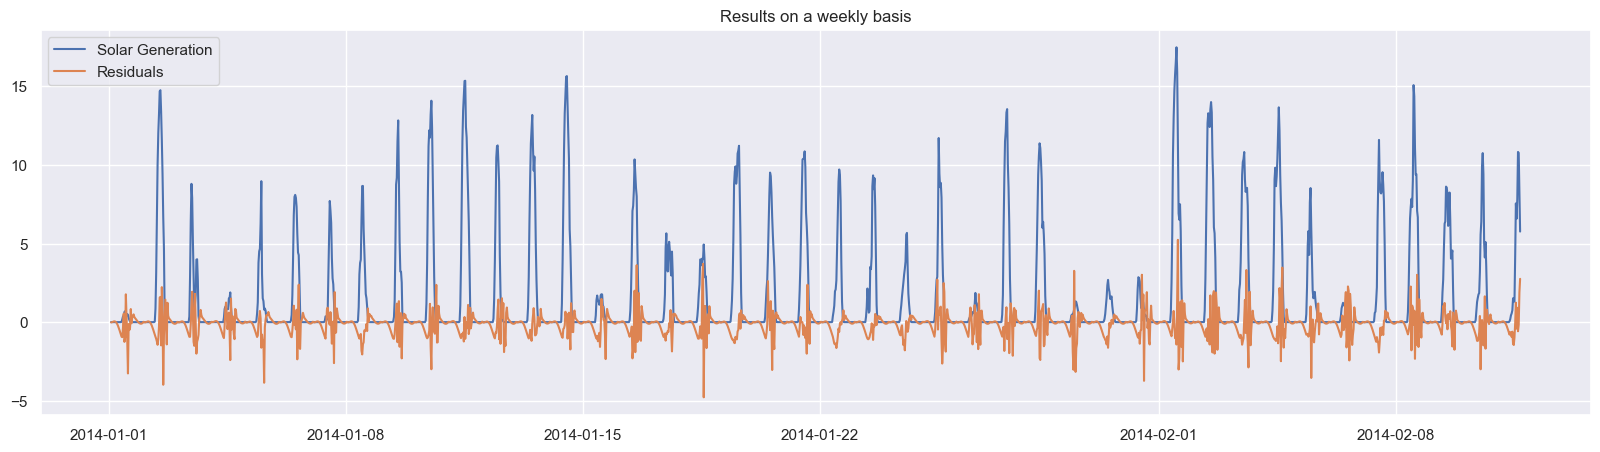

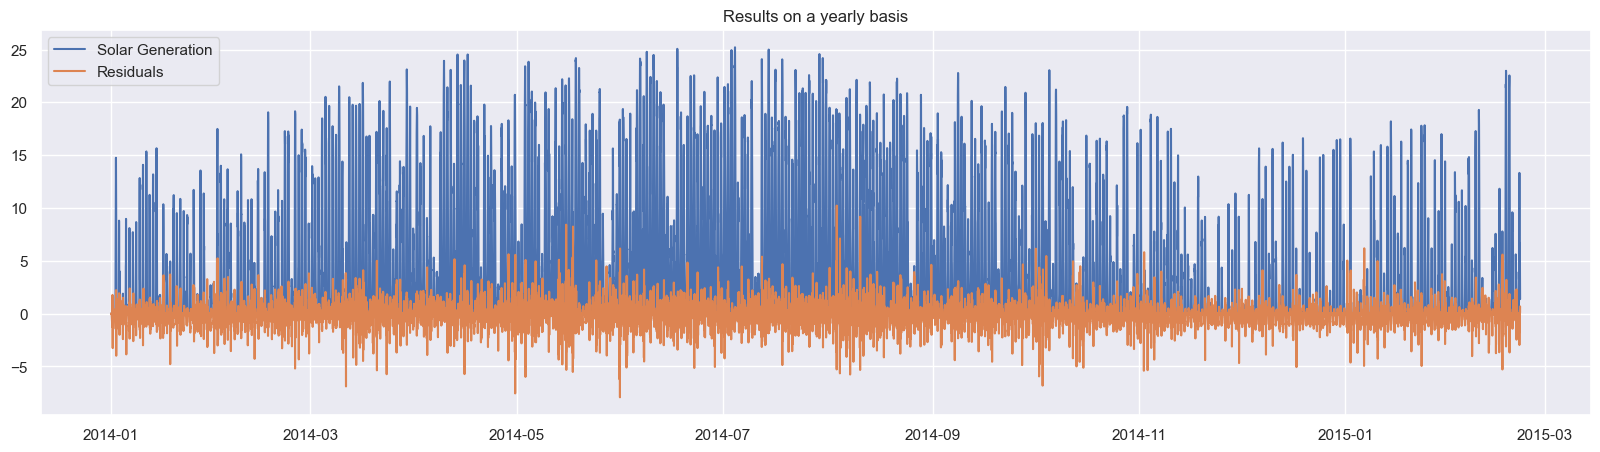

In [170]:
# Residuals
Rt = Yt_AR - features@params
fig, axs = plt.subplots(1,1,figsize=(20,5))
axs.plot(solar_gsp_groupC_df["datetime_gmt"][2:2000],Yt[2:2000], label='Solar Generation')
axs.plot(solar_gsp_groupC_df["datetime_gmt"][2:2000],Rt[:1998], label='Residuals')
axs.set_title('Results on a weekly basis')
axs.legend()

fig, axs = plt.subplots(1,1,figsize=(20,5))
axs.plot(solar_gsp_groupC_df["datetime_gmt"][2:20002],Yt[2:20002], label='Solar Generation')
axs.plot(solar_gsp_groupC_df["datetime_gmt"][2:20002],Rt[:20000], label='Residuals')
axs.set_title('Results on a yearly basis')
axs.legend();

## 3) Residuals Distribution (after having deseasonalized and removed AR terms) 

Residuals distribution after having deseasonalized and removed the AR(1), AR(2), AR(48), AR(49) terms

In [171]:
mu_Rt = Rt.mean()
std_Rt = Rt.std()

C:\Users\Utente\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


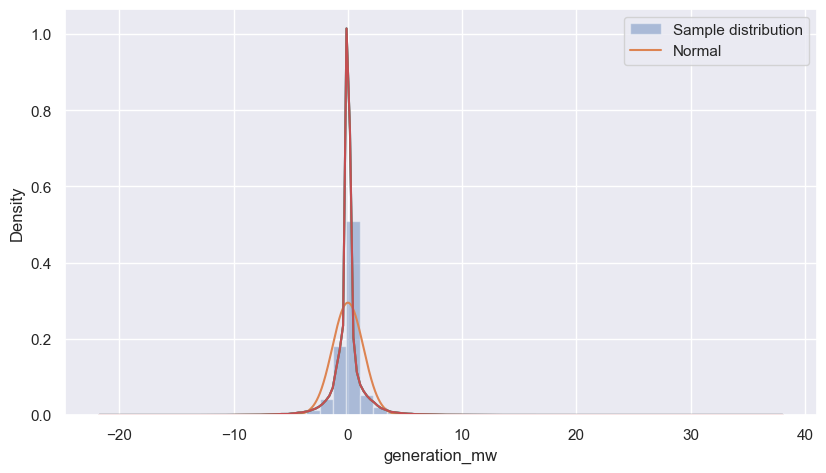

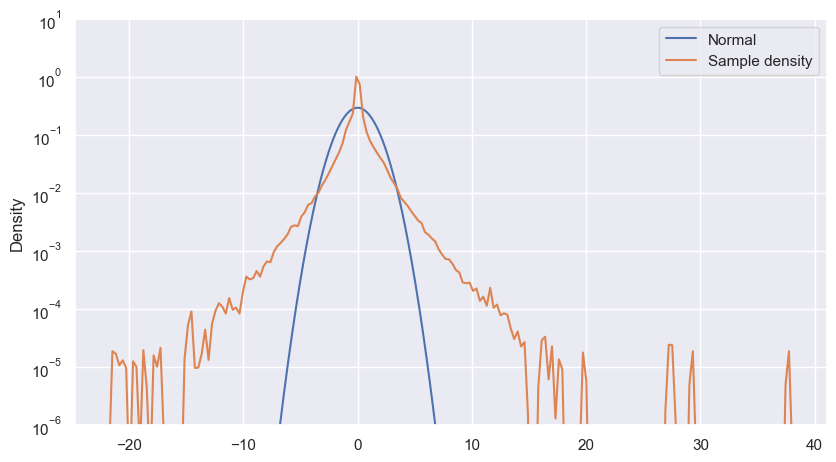

In [172]:
x = np.linspace(-10,10,10000)

sns.set(rc={'figure.figsize':(9.7,5.27)})
sns.distplot(Rt, label='Sample distribution')
plt.plot(x, norm.pdf(x, mu_Rt, std_Rt), label='Normal')
plt.legend()

# Density estimation
x_values = sns.kdeplot(Rt).get_lines()[0].get_xdata()
kde_values = sns.kdeplot(Rt).get_lines()[0].get_ydata()

fig, axs = plt.subplots(1,1)
axs.plot(x, norm.pdf(x, mu_Rt, std_Rt), label='Normal')
axs.plot(x_values, kde_values, label='Sample density')
axs.set_ylim([1e-6,10])
axs.set_ylabel("Density")
axs.set_yscale('log')
axs.legend()


## Augmented Dickey-Fuller unit root test

In [173]:
res = adfuller(Yt)

print("test statistic: ", res[0])
print("p-value: ", res[1])

test statistic:  -22.577463911409136
p-value:  0.0


# Solar Production Group P

## 1) Seasonality 

In [174]:
solar_gsp_groupP_df["generation_mw"].describe()

count    139729.000000
mean         14.560682
std          25.548016
min           0.000000
25%           0.000000
50%           0.024599
75%          18.959306
max         150.477216
Name: generation_mw, dtype: float64

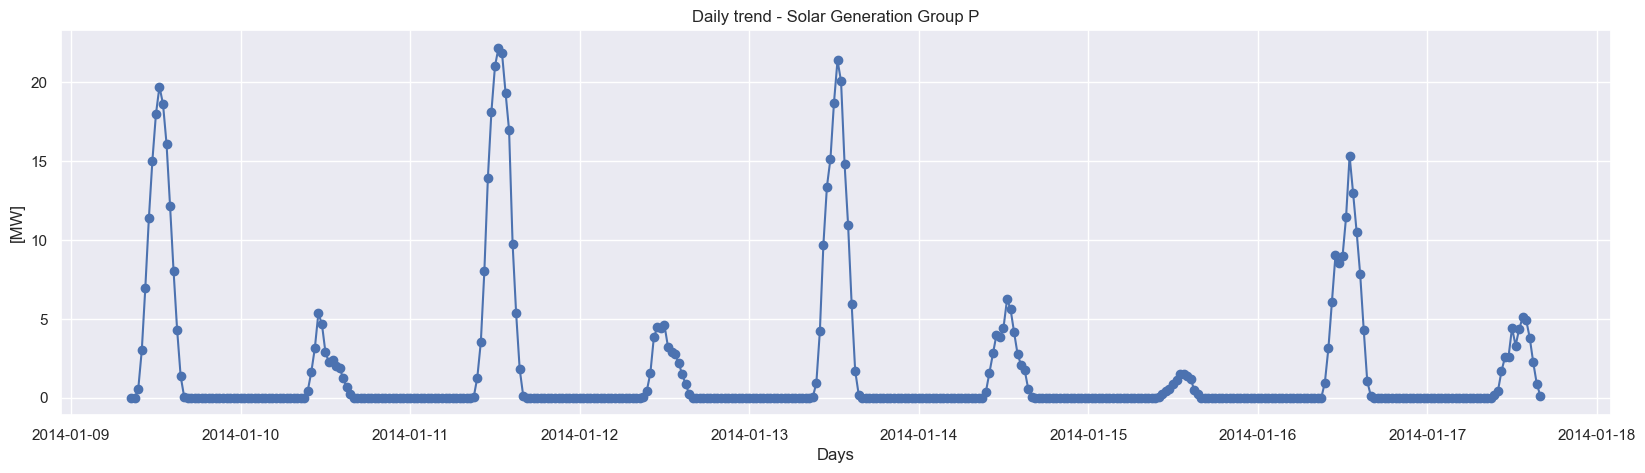

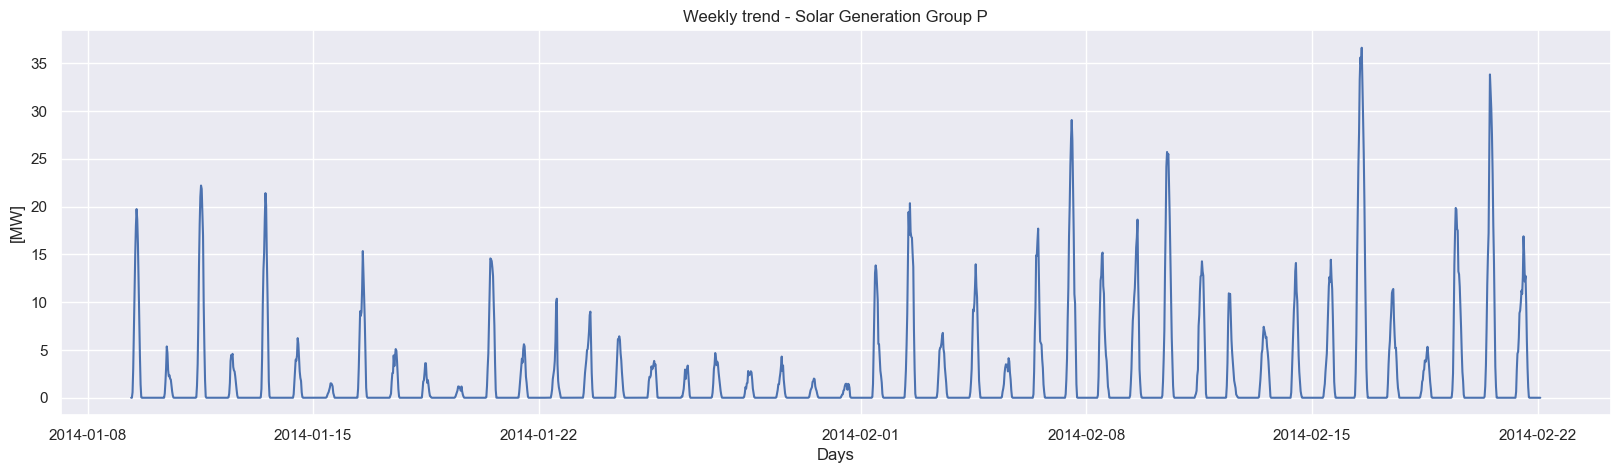

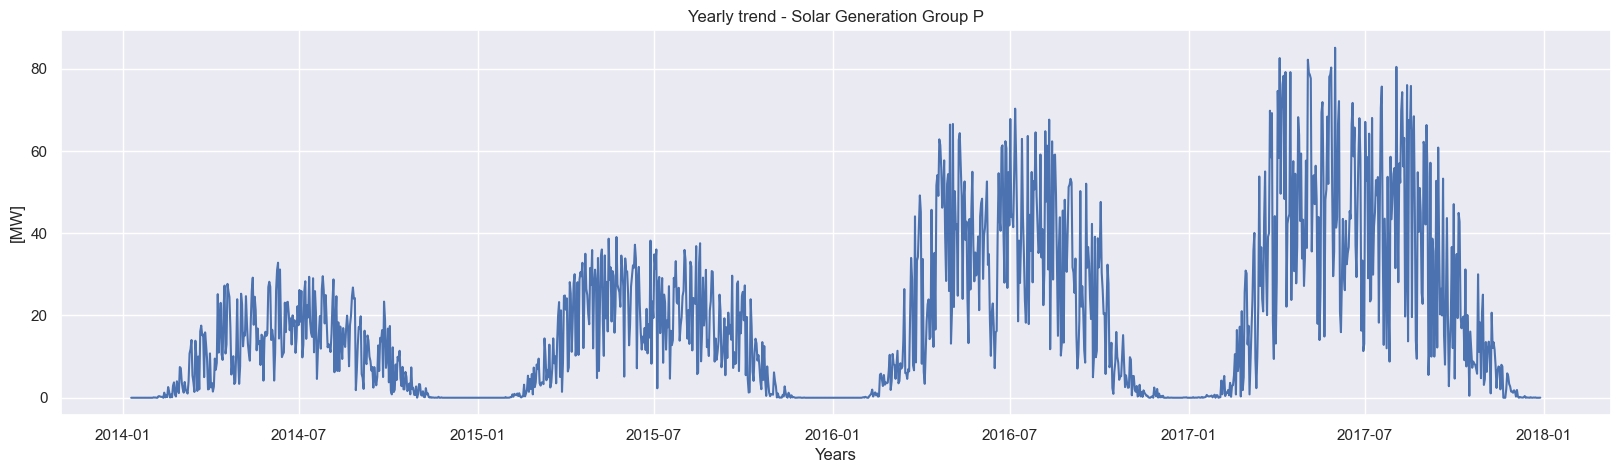

In [175]:
fig, axs = plt.subplots(1,1, figsize=(20,5))
axs.plot(solar_gsp_groupP_df['datetime_gmt'][400:800], solar_gsp_groupP_df['generation_mw'][400:800], '-o')
axs.set_title("Daily trend - Solar Generation Group P")
axs.set_xlabel("Days");
axs.set_ylabel("[MW]");

fig, axs = plt.subplots(1,1, figsize=(20,5))
axs.plot(solar_gsp_groupP_df['datetime_gmt'][400:2500], solar_gsp_groupP_df['generation_mw'][400:2500])
axs.set_title("Weekly trend - Solar Generation Group P")
axs.set_xlabel("Days");
axs.set_ylabel("[MW]");

fig, axs = plt.subplots(1,1, figsize=(20,5))
axs.plot(solar_gsp_groupP_df['datetime_gmt'][400:70000:48], solar_gsp_groupP_df['generation_mw'][400:70000:48])
axs.set_title("Yearly trend - Solar Generation Group P")
axs.set_xlabel("Years");
axs.set_ylabel("[MW]");

## 2) Partial Auto Correlation Function PACF

In [176]:
def Seasonality_Components_Solar(t, dow, doy, clock_hour, datetime):
    # seasonality on yearly scale
    wy = 2*np.pi/365
    month = datetime.dt.month
    is_summer = (month > 5)*(month < 9)
    # seasonality on weekly scale: we look for weekend days
    is_saturday = dow == 'Saturday'
    is_sunday = dow == 'Sunday'
    day_of_week = 1*(dow=='Monday')+2*(dow=='Tuesday')+3*(dow=='Wednesday')+4*(dow=='Thursday')+5*(dow=='Friday') \
                +6*(dow=='Saturday')+7*(dow=='Sunday')
    ww = 2*np.pi/7
    # seasonality on daily scale
    wd = 2*np.pi/48
    daily_hours = 1*(clock_hour < 36)*(clock_hour > 12)
    
    
    St = np.array([np.ones(doy.shape), t*daily_hours, np.cos(wy*doy)*daily_hours, np.sin(wy*doy)*daily_hours,
                   np.cos(wy*doy)*is_summer*daily_hours, np.sin(wy*doy)*is_summer*daily_hours, 
                   is_saturday, is_sunday, np.cos(ww*day_of_week)*daily_hours,np.sin(ww*day_of_week)*daily_hours, daily_hours,
                   #np.cos(ww*day_of_week)*np.cos(wd*clock_hour)*daily_hours, np.sin(ww*day_of_week)*np.sin(wd*clock_hour)*daily_hours,
                   np.cos(wd*clock_hour)*daily_hours, np.sin(wd*clock_hour)*daily_hours, np.cos(wd*clock_hour)*np.sin(wd*clock_hour)*daily_hours,
                   np.cos(2*wy*clock_hour), np.sin(2*wy*clock_hour),
                   np.cos(2*wd*clock_hour), np.sin(2*wd*clock_hour)]).T
    return St

### Trend and Seasonality Description

In [177]:
St = Seasonality_Components_Solar(solar_gsp_groupP_df["t"],solar_gsp_groupP_df["dow"], solar_gsp_groupP_df["doy"], solar_gsp_groupP_df["clock_hour"], solar_gsp_groupP_df["datetime_gmt"])
Yt = solar_gsp_groupP_df['generation_mw'] #Target to predict

model = sm.OLS(Yt, St)
results = model.fit()
params = results.params
print("Parameters: ", results.params)
print("RMSE: ", RMSE(Yt, St@params))

Parameters:  const   -314.226581
x1        13.582384
x2       -12.501063
x3         3.990958
x4         2.833192
x5        -1.806263
x6        -0.259277
x7        -0.145875
x8         0.080907
x9        -0.056221
x10     -410.765461
x11     -384.772878
x12      402.549481
x13      433.301794
x14      323.562317
x15      157.294013
x16       -6.726247
x17      -30.012552
dtype: float64
RMSE:  17.315681582820936


In [178]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          generation_mw   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     9672.
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:11:26   Log-Likelihood:            -5.9672e+05
No. Observations:              139729   AIC:                         1.193e+06
Df Residuals:                  139711   BIC:                         1.194e+06
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -314.2266     61.853     -5.080      0.000    -435.457    -192.996
x1            13.5824      0.233     58.296      0.000      13.126      14.039
x2           -12.5011      0.138    -90.441      0.000     -12.772     -12.230
x3             3.9910      0.103     38.650      0.000       3.789       4.193
x4             2.8332      0.259     10.937      0.000       2.325       3.341
x5            -1.8063      0.322     -5.618      0.000      -2.436      -1.176
x6            -0.2593      0.153     -1.700      0.089      -0.558       0.040
x7            -0.1459      0.152     -0.957      0.339      -0.445       0.153
x8             0.0809      0.111      0.729      0.466      -0.137       0.299
x9            -0.0562      0.101     -0.559      0.576      -0.253       0.141
x10         -410.7655     18.440    -22.276      0.000    -446.908    -374.623
x11         -384.7729     15.560    -24.728      0.000    -415.271    -354.275
x12          402.5495     18.023     22.336      0.000     367.225     437.874
x13          433.3018     12.450     34.803      0.000     408.900     457.704
x14          323.5623     62.112      5.209      0.000     201.825     445.300
x15          157.2940     12.039     13.065      0.000     133.698     180.890
x16           -6.7262      0.683     -9.844      0.000      -8.065      -5.387
x17          -30.0126      1.331    -22.543      0.000     -32.622     -27.403
==============================================================================
Omnibus:                    39386.185   Durbin-Watson:                   0.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           165266.660
Skew:                           1.339   Prob(JB):                         0.00
Kurtosis:                       7.606   Cond. No.                     3.16e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

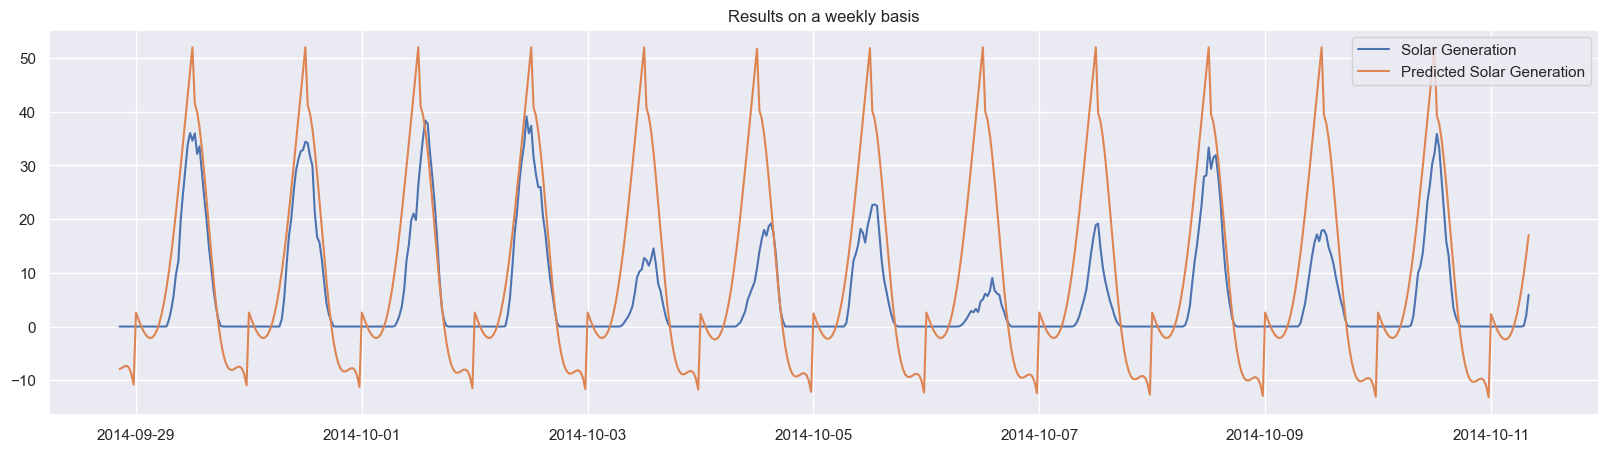

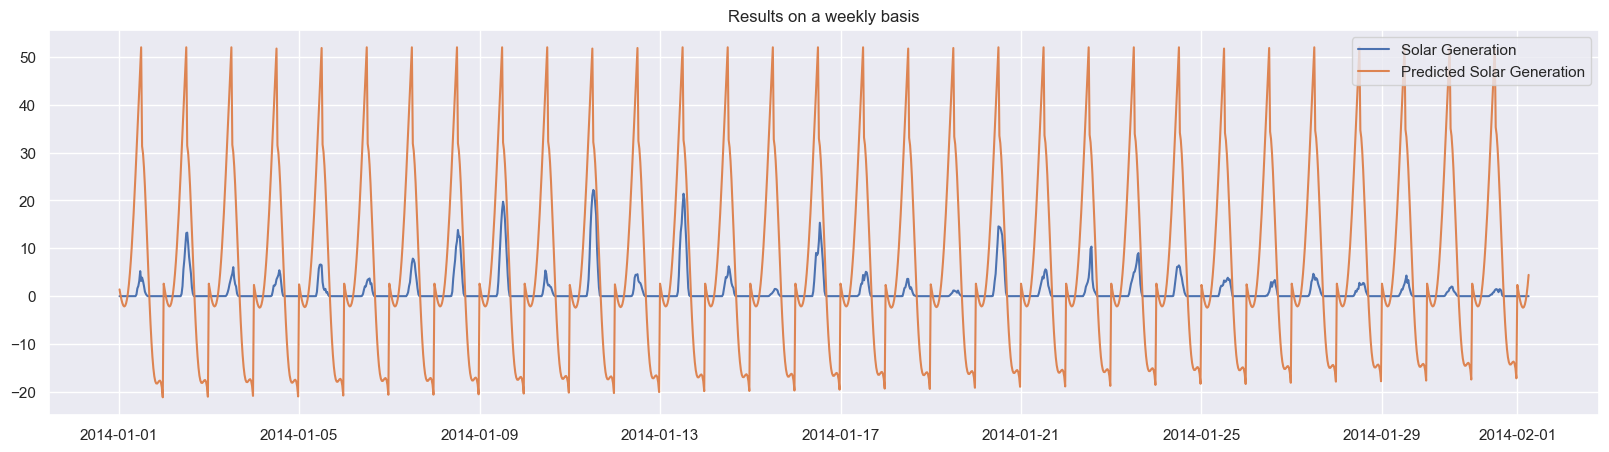

In [179]:
fig, axs = plt.subplots(1,1,figsize=(20,5))
axs.plot(solar_gsp_groupP_df["datetime_gmt"][13000:13600],Yt[13000:13600], label='Solar Generation')
axs.plot(solar_gsp_groupP_df["datetime_gmt"][13000:13600],(St@params)[13000:13600], label='Predicted Solar Generation')
axs.set_title('Results on a weekly basis')
axs.legend()

fig, axs = plt.subplots(1,1,figsize=(20,5))
axs.plot(solar_gsp_groupP_df["datetime_gmt"][:1500],Yt[:1500], label='Solar Generation')
axs.plot(solar_gsp_groupP_df["datetime_gmt"][:1500],(St@params)[:1500], label='Predicted Solar Generation')
axs.set_title('Results on a weekly basis')
axs.legend()



### Deseasonalizing process
We define Xt := Yt - St 

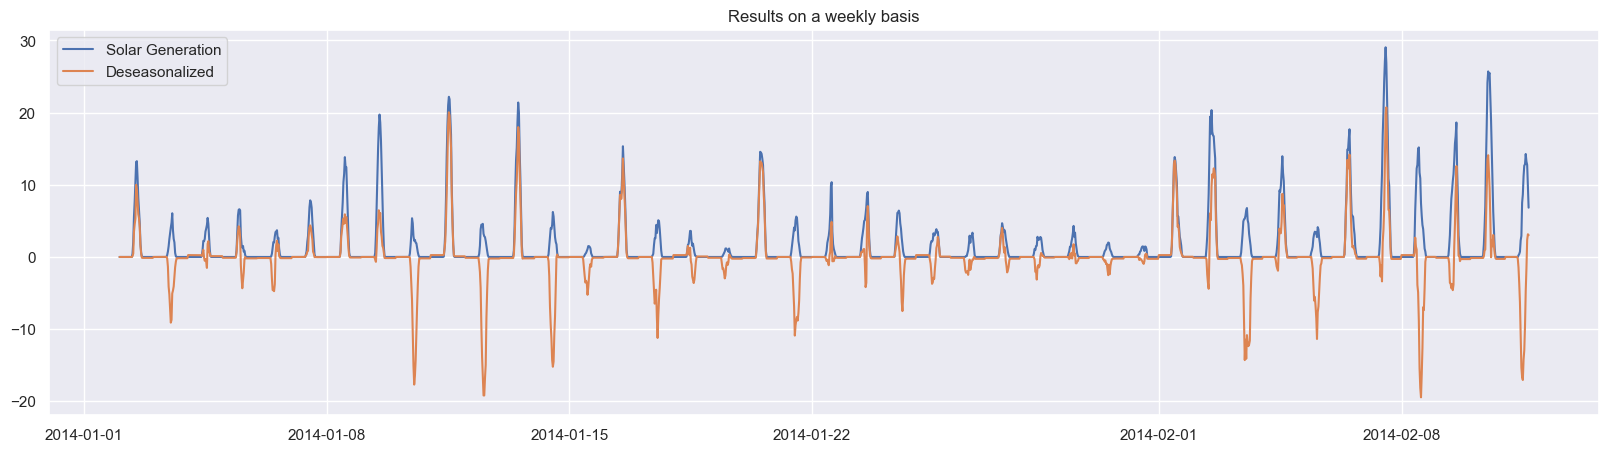

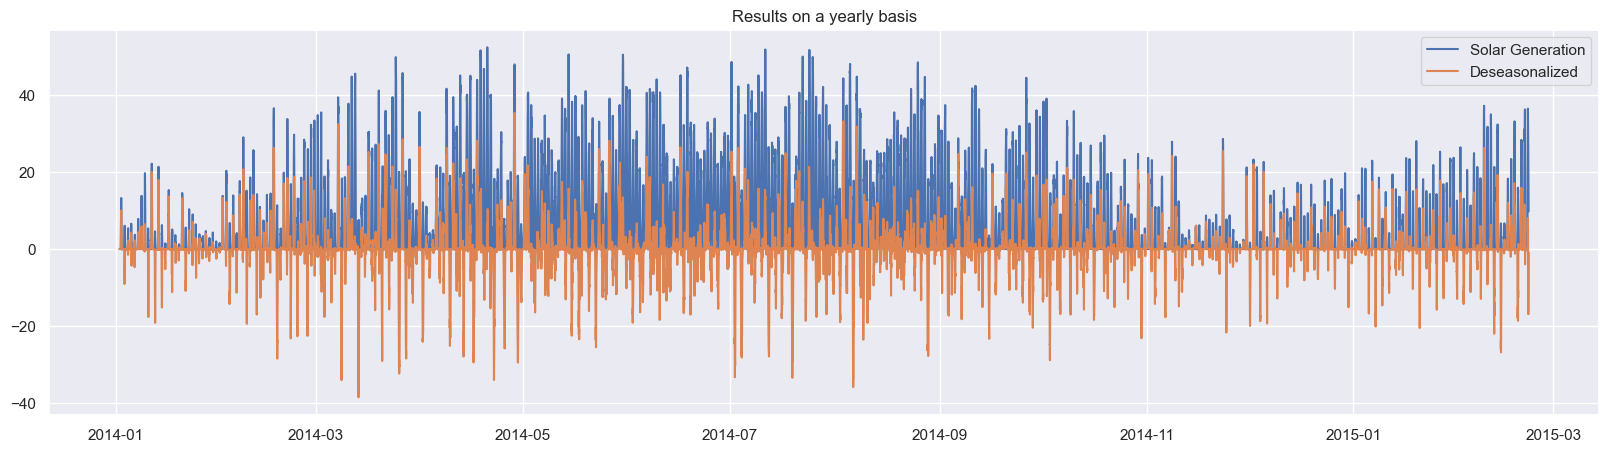

In [180]:
Xt = np.array((Yt - St@params)[48:]) - np.array((Yt - St@params)[:-48])
fig, axs = plt.subplots(1,1,figsize=(20,5))
axs.plot(solar_gsp_groupP_df["datetime_gmt"][48:2000],Yt[48:2000], label='Solar Generation')
axs.plot(solar_gsp_groupP_df["datetime_gmt"][48:2000],Xt[:2000-48], label='Deseasonalized')
axs.set_title('Results on a weekly basis')
axs.legend()

fig, axs = plt.subplots(1,1,figsize=(20,5))
axs.plot(solar_gsp_groupP_df["datetime_gmt"][48:20000],Yt[48:20000], label='Solar Generation')
axs.plot(solar_gsp_groupP_df["datetime_gmt"][48:20000],Xt[:20000-48], label='Deseasonalized')
axs.set_title('Results on a yearly basis')
axs.legend();

C:\Users\Utente\AppData\Local\Temp\ipykernel_9068\3153571102.py:4: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(range(400), acf(Xt, nlags=399), 'o')
C:\Users\Utente\AppData\Local\Temp\ipykernel_9068\3153571102.py:11: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(range(400), pacf(Xt, nlags=399), 'o')


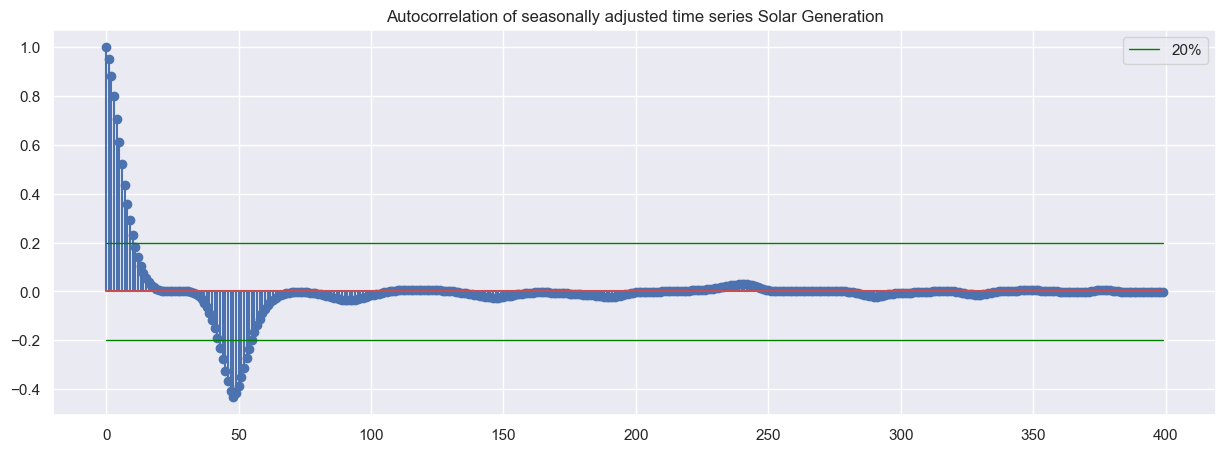

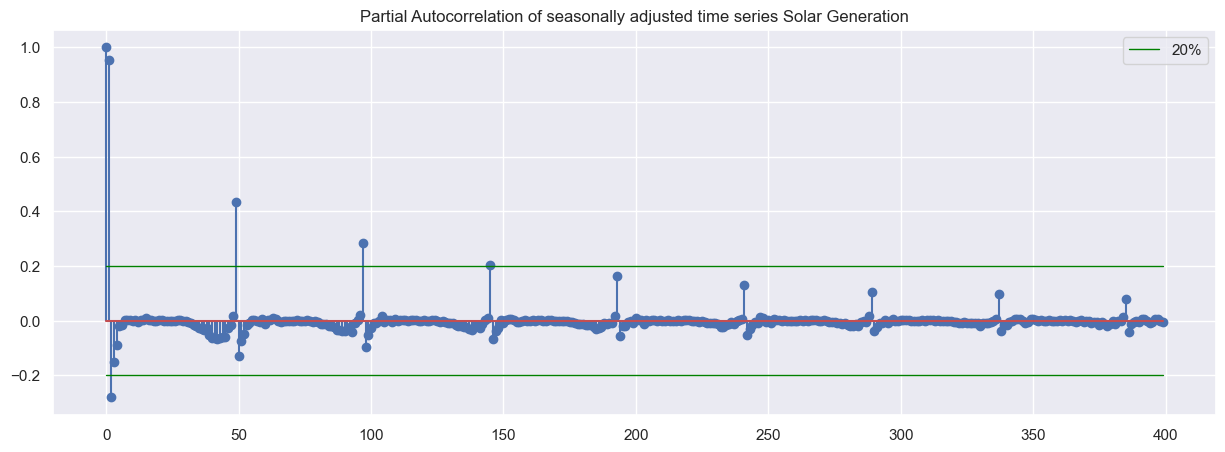

In [181]:
from statsmodels.tsa.stattools import pacf, acf

fig, axs = plt.subplots(1,1,figsize=(15,5))
plt.stem(range(400), acf(Xt, nlags=399), 'o')
plt.plot(range(400), 0.2*np.ones(400,), color='green', linewidth=1, label='20%')
plt.plot(range(400), -0.2*np.ones(400,), color='green', linewidth=1)
plt.title('Autocorrelation of seasonally adjusted time series Solar Generation');
plt.legend()

fig, axs = plt.subplots(1,1,figsize=(15,5))
plt.stem(range(400), pacf(Xt, nlags=399), 'o')
plt.plot(range(400), 0.2*np.ones(400,), color='green', linewidth=1, label='20%')
plt.plot(range(400), -0.2*np.ones(400,), color='green', linewidth=1)
plt.title('Partial Autocorrelation of seasonally adjusted time series Solar Generation');
plt.legend()

The Partial Autocorrelation plot suggests to introduce four AR terms: lag 1, lag 2, lag 48 (daily)

Yt = params*St + beta1 * Y(t-1) + beta2 * Y(t-2) + beta3 * Y(t-48) + Rt


In [182]:
Yt_AR = solar_gsp_groupP_df['generation_mw'].iloc[336:]
St_AR = Seasonality_Components_Solar(solar_gsp_groupP_df["t"].iloc[336:],solar_gsp_groupP_df["dow"].iloc[336:], solar_gsp_groupP_df["doy"].iloc[336:], solar_gsp_groupP_df["clock_hour"].iloc[336:], solar_gsp_groupP_df["datetime_gmt"].iloc[336:])
features = np.c_[St_AR, solar_gsp_groupP_df['generation_mw'].iloc[336-1:-1], solar_gsp_groupP_df['generation_mw'].iloc[336-2:-2],
                solar_gsp_groupP_df['generation_mw'].iloc[336-48:-48]]

model = sm.OLS(Yt_AR, features)
results = model.fit()
params = results.params
print("Parameters: ", results.params)
print("RMSE: ", RMSE(Yt_AR, features@params))

Parameters:  const   -873.603157
x1        -0.746829
x2         0.444259
x3        -0.136704
x4        -0.269384
x5         0.089101
x6        -0.001446
x7        -0.002027
x8         0.007672
x9         0.013122
x10      179.145854
x11        4.308670
x12     -176.855369
x13       -0.471465
x14      880.898365
x15      148.647144
x16       -7.441480
x17      -17.984998
x18        1.384091
x19       -0.435083
x20        0.035696
dtype: float64
RMSE:  3.3991310309455653


In [183]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          generation_mw   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                 3.874e+05
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:12:20   Log-Likelihood:            -3.6834e+05
No. Observations:              139393   AIC:                         7.367e+05
Df Residuals:                  139372   BIC:                         7.369e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -873.6032     12.759    -68.468      0.000    -898.611    -848.595
x1            -0.7468      0.047    -15.852      0.000      -0.839      -0.654
x2             0.4443      0.029     15.486      0.000       0.388       0.500
x3            -0.1367      0.020     -6.681      0.000      -0.177      -0.097
x4            -0.2694      0.051     -5.287      0.000      -0.369      -0.170
x5             0.0891      0.063      1.412      0.158      -0.035       0.213
x6            -0.0014      0.030     -0.048      0.962      -0.060       0.057
x7            -0.0020      0.030     -0.068      0.946      -0.061       0.057
x8             0.0077      0.022      0.351      0.725      -0.035       0.050
x9             0.0131      0.020      0.664      0.507      -0.026       0.052
x10          179.1459      3.690     48.544      0.000     171.913     186.379
x11            4.3087      3.069      1.404      0.160      -1.707      10.324
x12         -176.8554      3.608    -49.019      0.000    -183.927    -169.784
x13           -0.4715      2.463     -0.191      0.848      -5.300       4.357
x14          880.8984     12.815     68.739      0.000     855.781     906.016
x15          148.6471      2.464     60.321      0.000     143.817     153.477
x16           -7.4415      0.137    -54.453      0.000      -7.709      -7.174
x17          -17.9850      0.274    -65.658      0.000     -18.522     -17.448
x18            1.3841      0.002    565.850      0.000       1.379       1.389
x19           -0.4351      0.002   -178.799      0.000      -0.440      -0.430
x20            0.0357      0.001     53.690      0.000       0.034       0.037
==============================================================================
Omnibus:                    35925.831   Durbin-Watson:                   2.159
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1953801.380
Skew:                           0.392   Prob(JB):                         0.00
Kurtosis:                      21.324   Cond. No.                     9.99e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.99e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Impact of Autoregressive term

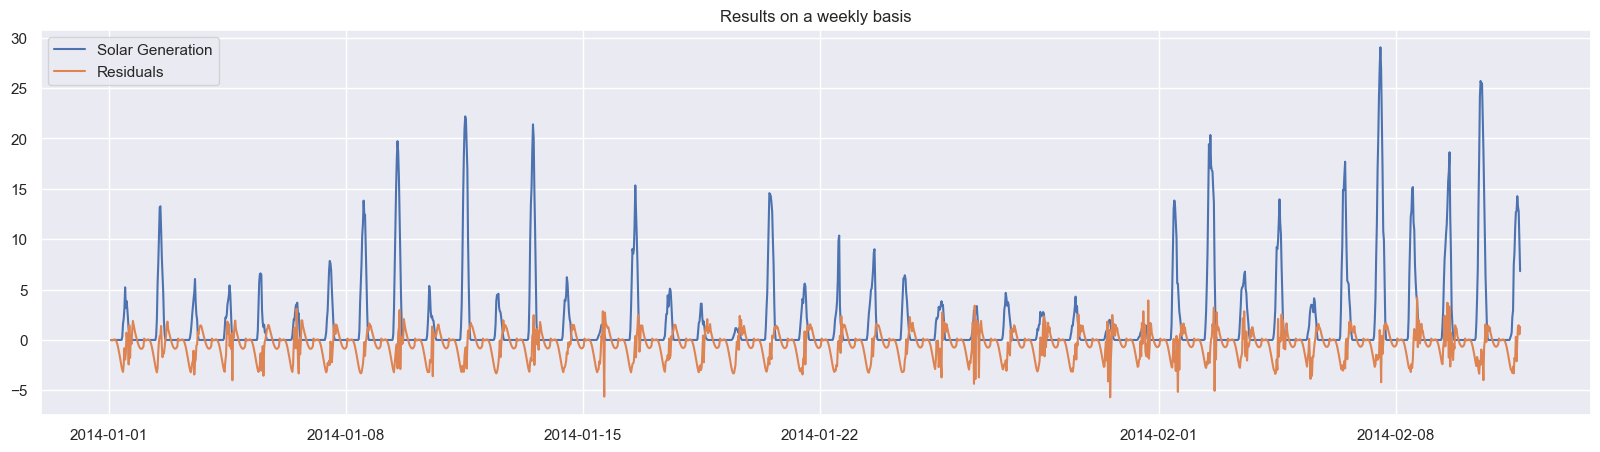

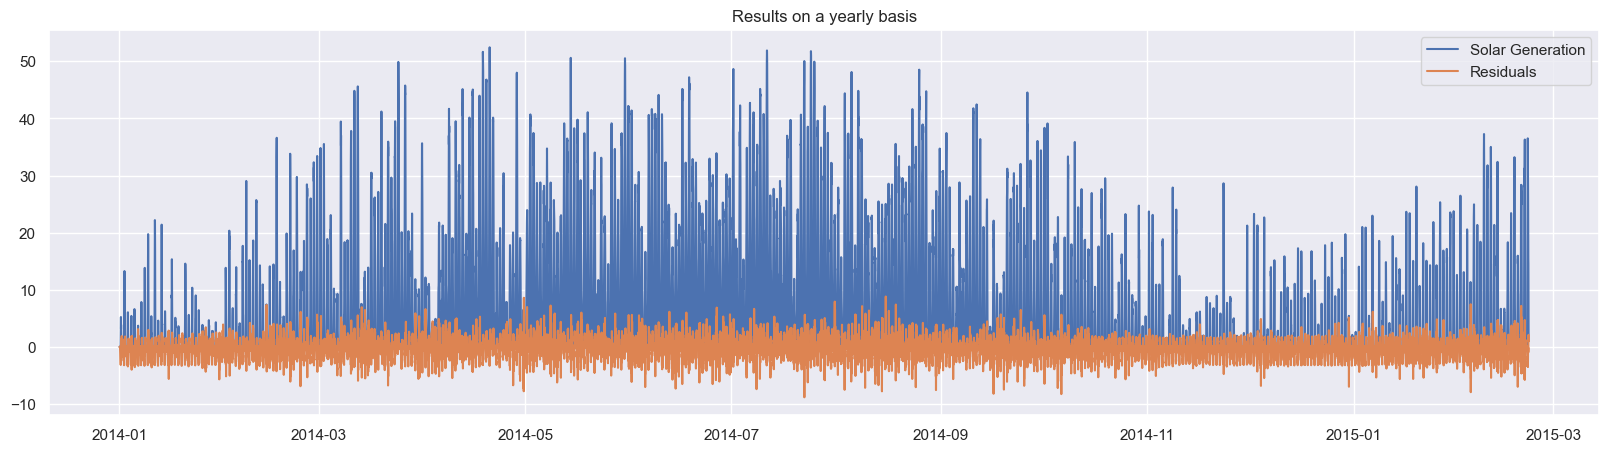

In [184]:
# Residuals
Rt = Yt_AR - features@params
fig, axs = plt.subplots(1,1,figsize=(20,5))
axs.plot(solar_gsp_groupP_df["datetime_gmt"][2:2000],Yt[2:2000], label='Solar Generation')
axs.plot(solar_gsp_groupP_df["datetime_gmt"][2:2000],Rt[:1998], label='Residuals')
axs.set_title('Results on a weekly basis')
axs.legend()

fig, axs = plt.subplots(1,1,figsize=(20,5))
axs.plot(solar_gsp_groupP_df["datetime_gmt"][2:20002],Yt[2:20002], label='Solar Generation')
axs.plot(solar_gsp_groupP_df["datetime_gmt"][2:20002],Rt[:20000], label='Residuals')
axs.set_title('Results on a yearly basis')
axs.legend();

## 3) Residuals Distribution (after having deseasonalized and removed AR terms) 

Residuals distribution after having deseasonalized and removed the AR(1), AR(2), AR(48) terms

In [185]:
mu_Rt = Rt.mean()
std_Rt = Rt.std()

C:\Users\Utente\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


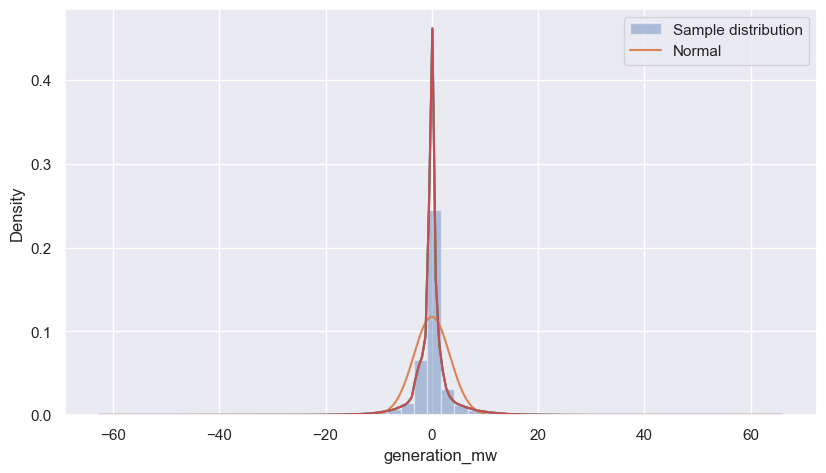

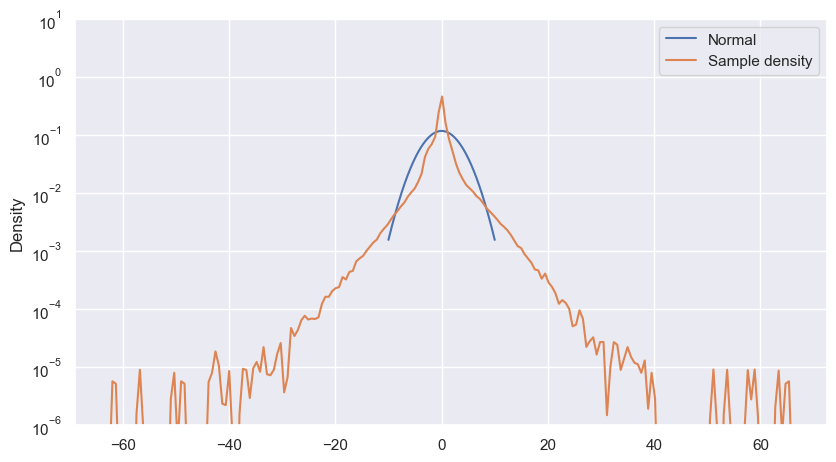

In [186]:
x = np.linspace(-10,10,10000)

sns.set(rc={'figure.figsize':(9.7,5.27)})
sns.distplot(Rt, label='Sample distribution')
plt.plot(x, norm.pdf(x, mu_Rt, std_Rt), label='Normal')
plt.legend()

# Density estimation
x_values = sns.kdeplot(Rt).get_lines()[0].get_xdata()
kde_values = sns.kdeplot(Rt).get_lines()[0].get_ydata()

fig, axs = plt.subplots(1,1)
axs.plot(x, norm.pdf(x, mu_Rt, std_Rt), label='Normal')
axs.plot(x_values, kde_values, label='Sample density')
axs.set_ylabel("Density")
axs.set_ylim([1e-6,10])
axs.set_yscale('log')
axs.legend()


## Augmented Dickey-Fuller unit root test

In [187]:
res = adfuller(Yt)

print("test statistic: ", res[0])
print("p-value: ", res[1])

test statistic:  -19.58904783147288
p-value:  0.0
